### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from ml_utils import edaDF
import toolbox as tb

In [2]:
# Download and load the data
import keras
import os

f_path_1 = "data/Euro_Salary.csv"
url_1 = "https://github.com/AkeemSemper/ml_data/raw/main/Euro_Salary.csv"
if not os.path.exists(f_path_1):
    file_1 = keras.utils.get_file(f_path_1, url_1)
    
df = pd.read_csv(f_path_1)

### Reload & Display Options

In [3]:
# Reload utility files

import importlib
importlib.reload(tb)

#from ml_eda import edaDF

<module 'toolbox' from 'c:\\Users\\msieb\\OneDrive\\Documents\\1 NAIT\\1 - DATA3950 MACHINE LEARNING\\Repository\\3950-assignment-2-mlsiebold\\toolbox.py'>

In [4]:
# Display options

# Display all columns
pd.set_option('display.max_columns', None)

# Display all rows
#pd.set_option('display.max_rows', None)

# Dispay all output
#pd.set_option('display.max_seq_items', None)            # Not sure this works 

# Change display format for float values (comma seperators, 2 decimals)
pd.options.display.float_format = '{:,.2f}'.format

# Set default figsize for workbook
plt.rcParams["figure.figsize"] = (12,6)

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure you publish it after having run it, all the output should be showing.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a "presentation version" at the bottom, where you show what you did, and the results. Basically, you start with the original data, you do some work to figure out what's needed, you try a few models and select the best. At the bottom, put what <i>you actually settled on</i>, i.e. after all the figuring and exploring, here's the code that goes from raw data to final results, and here's what the results were. I should be able to read this part and understand what you did clearly:
    <ul>
        <li> Please make a pipeline that does the prep work - you may need some exploration or several trials before settling on what exactly to use, that's normal. Once you've settled, build that into a pipeline so it's clear and repeatable.
        <li> What you settled on for data cleaning, along with what prompted it. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Model selection - between selecting a model style and tuning it with hyperparameters, what did you test and what won?
        <li> Overall, how good was your model and what things may make sense to try to do even better? 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

<b>The biggest challenge here is translating the data into something useful and clean. This will probably require a bit of exploration, examining the data, thinking about what it means, trying something, then making a model to see what the results are. In particular, think about what value some of the less clean bits of data my hold - binning/grouping, numerical transformations, outlier removal, etc... are all likely to be useful somewhere. You almost certainly need to look at it column by column and make a decision, I'll apologize up front, it isn't the most fun process in the world. There is not one specific correct answer.</b>

### Basic Cleaning

In [5]:
#  Remove whitespaces and weird characters

import unicodedata

df = df.apply(lambda col: col.map(tb.clean_string))     # Clean entire df
df.columns = df.columns.map(tb.clean_string)            # Clean column headers

In [6]:
# Replace null-like values with NaN

tb.clean_null_like(df, columns=None)

### Data Dictionary

In [7]:
# Create data dictionary

data_dict = pd.DataFrame({
    'Dtype': df.dtypes,
    'Semantic Type': None,
    'Desc': None,
    '# of Nulls': df.isna().sum(),
    '# of Unique Values': df.nunique()
    })                                      #.reset_index(names='Column')

data_dict.index.name = 'Column'             # Give the index a name

In [8]:
# Create description dictionary scaffold to add manually input column descriptions to data dictionary

# Create list of columns
cols = df.columns.to_list()

# Scaffold for descriptions
desc_dict = {col: '' for col in cols}
#desc_dict

# Scaffold for semantics (numeric, categorical)
semantic_dict = {col: '' for col in cols}
#semantic_dict

In [9]:
# Manually update description dictionary

desc_dict = {
 'timestamp': 'Date and time survey response was submitted (acts as survey submission identifier)',
 'age': "Respondent's age in years",
 'gender': "Respondent's self-report gender",
 'city': 'City in which the respondent works (primarily German cities, with a few internationaly cities)',
 'position': 'Current job title or primary role',
 'total years of experience': 'Total number of years the respondent has worked in their profession',
 'years of experience in germany': 'Number of years the respondent has worked specifically in Germany',
 'seniority level': 'Self‑reported seniority',
 'your main technology / programming language': 'Primary programming language or technology used in the respondent’s job',
 'other technologies/programming languages you use often': 'Additional languages, frameworks, or tools the respondent frequently uses',
 'yearly brutto salary (without bonus and stocks) in eur': 'Annual gross base salary in euros, excluding bonuses and stock compensation',
 'yearly bonus + stocks in eur': 'Annual bonus and/or stock compensation in euros',
 'number of vacation days': 'Number of paid vacation days per year',
 'employment status': 'Type of employment',
 'contract duration': 'Type of employment contract',
 'main language at work': 'Primary language used in the workplace',
 'company size': 'Approximate number of employees in the respondent’s company',
 'company type': 'Type of organization respondent is employed for'}

In [10]:
# Manually update semantic type dictionary

semantic_dict = {
 'timestamp': 'categorical nominal',
 'age': 'numeric discrete',
 'gender': 'categorical nominal',
 'city': 'categorical nominal',
 'position': 'categorical nominal',
 'total years of experience': 'numeric continuous',
 'years of experience in germany': 'numeric continuous',
 'seniority level': 'categorical ordinal',
 'your main technology / programming language': 'categorical nominal',
 'other technologies/programming languages you use often': 'categorical nominal',
 'yearly brutto salary (without bonus and stocks) in eur': 'numeric continuous',
 'yearly bonus + stocks in eur': 'numeric continuous',
 'number of vacation days': 'numeric discrete',
 'employment status': 'categorical nominal',
 'contract duration': 'categorical nominal',
 'main language at work': 'categorical nominal',
 'company size': 'categorical ordinal',
 'company type': 'categorical nominal'}

In [11]:
# Map descriptions and semantics to data dictionary 

#data_dict['Desc'] = data_dict['Column'].map(desc_dict)
#data_dict['Semantic Type'] = data_dict['Column'].map(semantic_dict)

data_dict['Desc'] = data_dict.index.map(desc_dict)
data_dict['Semantic Type'] = data_dict.index.map(semantic_dict)

In [12]:
# Check my handywork

data_dict

,Dtype,Semantic Type,Desc,# of Nulls,# of Unique Values
Column,,,,,
timestamp,string[python],categorical nominal,Date and time survey response was submitted (a...,0,1248
age,float64,numeric discrete,Respondent's age in years,27,40
gender,string[python],categorical nominal,Respondent's self-report gender,10,3
city,string[python],categorical nominal,City in which the respondent works (primarily ...,0,106
position,string[python],categorical nominal,Current job title or primary role,6,133
total years of experience,string[python],numeric continuous,Total number of years the respondent has worke...,16,48
years of experience in germany,string[python],numeric continuous,Number of years the respondent has worked spec...,32,52
seniority level,string[python],categorical ordinal,Self‑reported seniority,12,21
your main technology / programming language,string[python],categorical nominal,Primary programming language or technology use...,128,206


In [13]:
# Save data dictionary to markdown file

data_dict.reset_index().to_csv('data_dictionary.tsv', sep='\t', index=False, encoding='utf-8-sig')

### Convert Dtypes

In [14]:
# Change dtypes based on semantic type

df = tb.apply_semantic_dtypes(df, data_dict, tb.semantic_to_dtype)

In [15]:
df.dtypes

Column
timestamp                                                 category
age                                                        float64
gender                                                    category
city                                                      category
position                                                  category
total years of experience                                  float64
years of experience in germany                             float64
seniority level                                           category
your main technology / programming language               category
other technologies/programming languages you use often    category
yearly brutto salary (without bonus and stocks) in eur     float64
yearly bonus + stocks in eur                               float64
number of vacation days                                    float64
employment status                                         category
contract duration                                      

### Define target

In [16]:
df['total_compensation'] = df['yearly brutto salary (without bonus and stocks) in eur'] + df['yearly bonus + stocks in eur']

### Create EDA object

In [17]:
target = 'total_compensation'
df_eda = edaDF(df, target=target)

### Basic EDA

In [18]:
# Total records

len(df)

1253

In [19]:
# Check for duplicates

df.duplicated().value_counts()

False    1253
Name: count, dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 19 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   timestamp                                               1253 non-null   category
 1   age                                                     1226 non-null   float64 
 2   gender                                                  1243 non-null   category
 3   city                                                    1253 non-null   category
 4   position                                                1247 non-null   category
 5   total years of experience                               1230 non-null   float64 
 6   years of experience in germany                          1195 non-null   float64 
 7   seniority level                                         1241 non-null   category
 8   your main technology / progr

In [21]:
# Basic stats

df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Column,,,,,,,,,,,
timestamp,1253,1248,24/11/2020 15:07:35,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,"1,226.00",NaN,NaN,NaN,32.51,5.66,20.00,29.00,32.00,35.00,69.00
gender,1243,3,male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,1253,106,berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
position,1247,133,software engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total years of experience,"1,230.00",NaN,NaN,NaN,9.08,11.90,0.00,5.00,8.00,12.00,383.00
years of experience in germany,"1,195.00",NaN,NaN,NaN,3.75,3.66,0.00,1.00,3.00,5.00,30.00
seniority level,1241,21,senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
your main technology / programming language,1125,206,python,212,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Number of unique values per feature

print('\033[1m# of unique values:\033[0m')
print(df.nunique())

# of unique values:
Column
timestamp                                                 1248
age                                                         40
gender                                                       3
city                                                       106
position                                                   133
total years of experience                                   42
years of experience in germany                              36
seniority level                                             21
your main technology / programming language                206
other technologies/programming languages you use often     561
yearly brutto salary (without bonus and stocks) in eur     201
yearly bonus + stocks in eur                               162
number of vacation days                                     36
employment status                                           10
contract duration                                            3
main language at work       

In [23]:
# Check for rows missing salary and bonuses

salary = 'yearly brutto salary (without bonus and stocks) in eur'
bonuses = 'yearly bonus + stocks in eur'

len(df[(df[salary].fillna(0)==0) & (df[bonuses].fillna(0)==0)])

0

In [25]:
# Check for rows missing a substantial amount of info

percent = 0.50                              
thresh = round(len(df.columns) * percent)    # Threshold value for missing fields per record

null_count = df.isna().sum(axis=1)          # Count nulls per row

df[null_count>thresh]

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
473,25/11/2020 03:27:34,NaN,<NA>,berlin,<NA>,NaN,NaN,<NA>,<NA>,<NA>,"99,999,999,999.00",NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
913,29/11/2020 19:42:21,24.00,male,berlin,ml engineer,3.00,NaN,<NA>,<NA>,<NA>,"90,000.00",NaN,NaN,<NA>,<NA>,<NA>,<NA>,startup,NaN
1180,20/12/2020 00:30:53,NaN,<NA>,berlin,<NA>,NaN,NaN,<NA>,<NA>,<NA>,"30,000.00",NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
1181,20/12/2020 00:31:23,NaN,<NA>,berlin,<NA>,NaN,NaN,<NA>,<NA>,<NA>,"111,111.00",NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
1231,08/01/2021 12:52:08,NaN,<NA>,munich,<NA>,NaN,NaN,<NA>,<NA>,<NA>,"70,000.00",NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN


In [26]:
# Drop records with less than 50% of fields completed

df = df[null_count <= thresh]
df.head()

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
0,24/11/2020 11:14:15,26.00,male,munich,software engineer,5.00,3.00,senior,typescript,"kotlin, javascript / typescript","80,000.00","5,000.00",30.00,full-time employee,unlimited contract,english,51-100,product,"85,000.00"
1,24/11/2020 11:14:16,26.00,male,berlin,backend developer,7.00,4.00,senior,ruby,<NA>,"80,000.00",NaN,28.00,full-time employee,unlimited contract,english,101-1000,product,NaN
2,24/11/2020 11:14:21,29.00,male,berlin,software engineer,12.00,6.00,lead,javascript / typescript,"javascript / typescript, docker","120,000.00","120,000.00",30.00,self-employed (freelancer),temporary contract,english,101-1000,product,"240,000.00"
3,24/11/2020 11:15:24,28.00,male,berlin,frontend developer,4.00,1.00,junior,javascript,<NA>,"54,000.00",NaN,24.00,full-time employee,unlimited contract,english,51-100,startup,NaN
4,24/11/2020 11:15:46,37.00,male,berlin,backend developer,17.00,6.00,senior,c# .net,".net, sql, aws, docker","62,000.00",NaN,29.00,full-time employee,unlimited contract,english,101-1000,product,NaN


In [27]:
# Confirm rows were dropped

len(df[null_count>thresh])

C:\Users\msieb\AppData\Local\Temp\ipykernel_5048\3748703787.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df[null_count>thresh])


0

In [28]:
# Checkstop for code run

forcestop = input("Force stop? (y/n): ").strip().lower()

if forcestop not in ("y", "yes"):
    raise Exception("Execution stopped by user")

In [29]:
# Check for rows missing a substantial amount of info

exc_col = ['timestamp', 'gender', 'employment status', 'main language at work']     # Exclude columns I intend to drop
null_count = df.drop(columns=exc_col).isna().sum(axis=1)  # Count nulls per row

df[null_count>8]

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
55,24/11/2020 11:33:08,NaN,male,berlin,software engineer,NaN,1.00,senior,php,<NA>,"75,000.00",NaN,NaN,full-time employee,<NA>,english,<NA>,<NA>,NaN


Value counts: 0    646
2    320
1    122
3     89
4     46
5     10
6      8
7      5
9      1
8      1
Name: count, dtype: int64


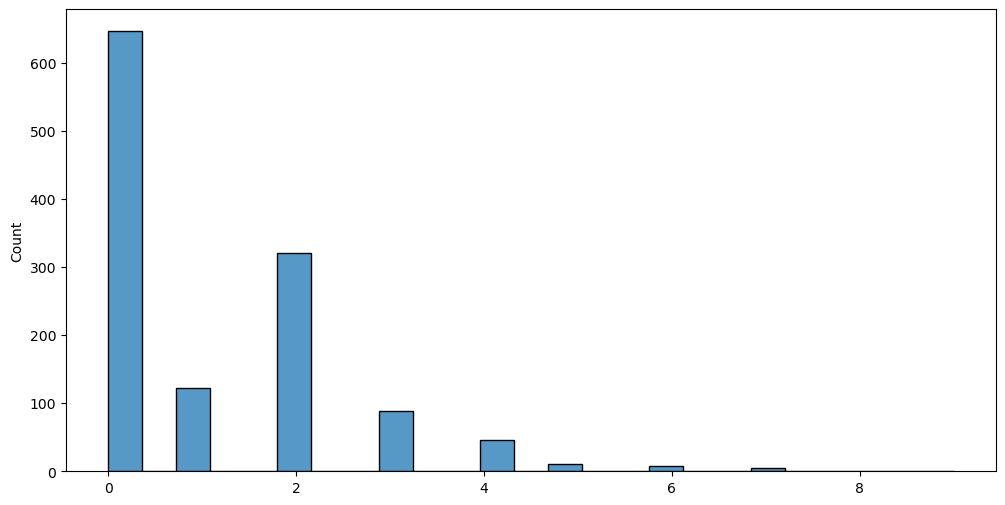

In [30]:
# Check distribution of missingness

sns.histplot(null_count);

print(f'Value counts: {null_count.value_counts()}')


In [31]:
df[salary].value_counts().sort_index()

yearly brutto salary (without bonus and stocks) in eur
10,001.00         2
10,164.00         1
11,000.00         1
11,500.00         1
12,000.00         2
                 ..
240,000.00        1
250,000.00        1
300,000.00        1
850,000.00        1
500,000,000.00    1
Name: count, Length: 199, dtype: int64

### Column Specific EDA

In [32]:
# Set column lists

num_cols = tb.detect_num_cols(df)
cat_cols = tb.detect_cat_cols(df)

### **'Timestamp'**
- **Inconsistencies:**
    - no value added
- **Actions taken:**
    - drop column

In [33]:
# Basic EDA

column = 'timestamp'
tb.eda_column_summary(df, column)

=== COLUMN: timestamp ===

DTYPE:
category

NON-NULL VALUES:
1,248

NULL VALUES:
0

UNIQUE VALUES:
1,243

BASIC STATS:
count                    1248
unique                   1243
top       24/11/2020 13:55:19
freq                        2
Name: timestamp, dtype: object

TOP VALUES:
timestamp
24/11/2020 13:55:19    2
24/11/2020 14:07:23    2
24/11/2020 15:07:35    2
25/11/2020 08:47:37    2
25/11/2020 18:28:01    2
Name: count, dtype: int64

BOTTOM VALUES:
timestamp
29/11/2020 19:42:21    0
25/11/2020 03:27:34    0
20/12/2020 00:30:53    0
20/12/2020 00:31:23    0
08/01/2021 12:52:08    0
Name: count, dtype: int64


In [34]:
# Check if any duplicate timestamps might be duplicate records

df[df[column].duplicated(keep=False)].sort_values(by=column)

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
234,24/11/2020 13:55:19,25.00,male,munich,ml engineer,1.00,1.00,middle,python,"python, c/c++, swift, matlab","65,000.00","2,000.00",30.00,full-time employee,unlimited contract,english,1000+,product,"67,000.00"
235,24/11/2020 13:55:19,32.00,male,berlin,engineering manager,9.00,5.00,lead,<NA>,"php, javascript / typescript, .net, sql, googl...","95,000.00","140,000.00",365.00,full-time employee,unlimited contract,english,1000+,product,"235,000.00"
246,24/11/2020 14:07:23,34.00,male,berlin,software engineer,14.00,5.00,senior,c#,"javascript / typescript, .net, sql, aws, docker","72,000.00",NaN,26.00,full-time employee,unlimited contract,english,101-1000,product,NaN
247,24/11/2020 14:07:23,37.00,male,berlin,team lead,12.00,10.00,head,python,"python, php, javascript / typescript, sql, docker","90,000.00",NaN,30.00,full-time employee,unlimited contract,english,11-50,consulting / agency,NaN
280,24/11/2020 15:07:35,33.00,male,frankfurt,software engineer,10.00,1.00,senior,.net,"javascript / typescript, sql, azure","26,400.00",NaN,NaN,self-employed (freelancer),unlimited contract,english,up to 10,startup,NaN
281,24/11/2020 15:07:35,28.00,male,berlin,frontend developer,8.00,5.00,senior,javascript,<NA>,"68,000.00",NaN,NaN,full-time employee,<NA>,<NA>,<NA>,<NA>,NaN
490,25/11/2020 08:47:37,29.00,male,munich,software engineer,8.00,6.00,middle,php,"javascript / typescript, sql","75,000.00",NaN,30.00,full-time employee,unlimited contract,english,1000+,product,NaN
491,25/11/2020 08:47:37,37.00,male,malta,software architect,18.00,NaN,head,go,"google cloud, kubernetes, docker, shell","156,000.00",0.00,0.00,self-employed (freelancer),unlimited contract,english,11-50,startup,"156,000.00"
665,25/11/2020 18:28:01,32.00,male,berlin,qa engineer,10.00,3.00,senior,js,"java / scala, google cloud, docker","81,000.00","45,000.00",30.00,full-time employee,unlimited contract,english,1000+,product,"126,000.00"
666,25/11/2020 18:28:01,32.00,male,cologne,devops,7.00,2.00,middle,k8s,"python, google cloud, kubernetes, docker","60,000.00",NaN,30.00,full-time employee,unlimited contract,english,101-1000,product,NaN


In [35]:
# Convert Timestamp to datetime 

df[column] = pd.to_datetime(df[column], errors='coerce')

C:\Users\msieb\AppData\Local\Temp\ipykernel_5048\1719035686.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[column] = pd.to_datetime(df[column], errors='coerce')
C:\Users\msieb\AppData\Local\Temp\ipykernel_5048\1719035686.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], errors='coerce')


In [36]:
# Look at date ranges

print(f'Oldest date: {df[column].min()}')
print(f'Most recent date: {df[column].max()}')

Oldest date: 2020-11-24 11:14:15
Most recent date: 2021-01-19 12:01:11


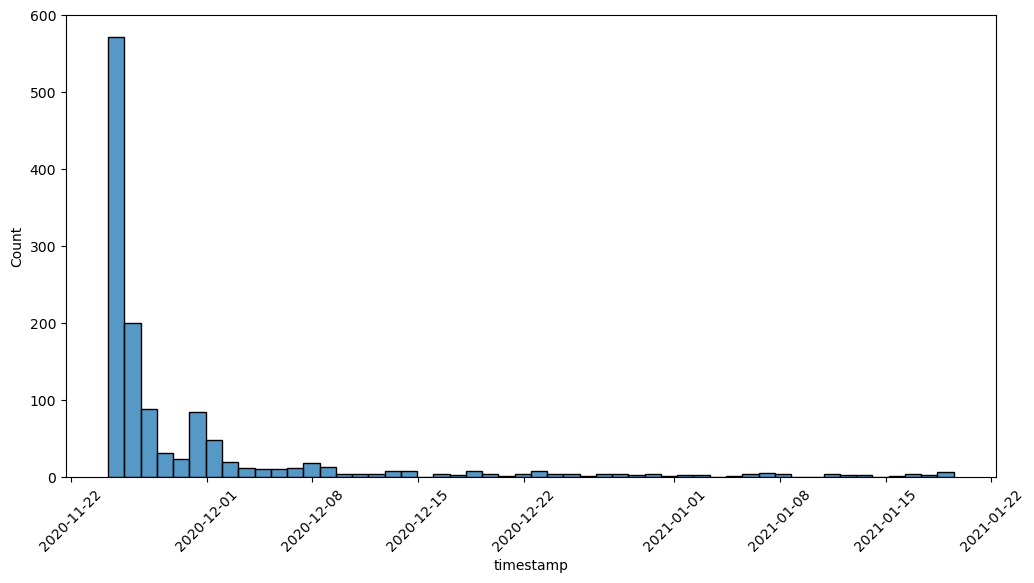

In [37]:
# Check distribution for funzies

sns.histplot(df, x=column)
plt.xticks(rotation=45);

##### **Observations**
- Duplicate Timestamp's look fine. No duplicate records
- Can't see any use for this column so drop it

### **'Age'**
- **Inconsistencies:**
    - null values
    - positive skew 
    - spike in distribution (age=30)
- **Actions taken:**
    - impute null values
    - standardize column (StandardScaler) or bin ages?
    - log transformation

In [38]:
# Basic EDA

column = 'age'
tb.eda_column_summary(df, column)

=== COLUMN: age ===

DTYPE:
float64

NON-NULL VALUES:
1,225

NULL VALUES:
23

UNIQUE VALUES:
40

BASIC STATS:
count   1,225.00
mean       32.52
std         5.66
min        20.00
25%        29.00
50%        32.00
75%        35.00
max        69.00
Name: age, dtype: float64

TOP VALUES:
age
30.00    110
32.00     94
33.00     94
28.00     87
31.00     87
Name: count, dtype: int64

BOTTOM VALUES:
age
50.00    1
21.00    1
20.00    1
69.00    1
52.00    1
Name: count, dtype: int64


In [39]:
# Look at age ranges

print(f'Youngest: {df[column].min()}')
print(f'Oldest: {df[column].max()}')


Youngest: 20.0
Oldest: 69.0


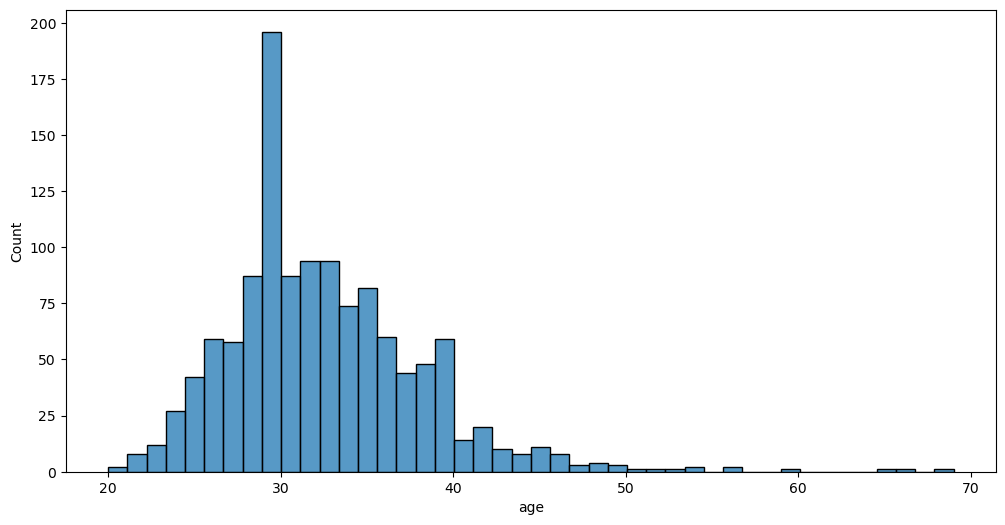

In [40]:
# Check distribution

sns.histplot(df, x=column);

In [41]:
# I wonder what that spike is...

df[column].value_counts().head(1)

age
30.00    110
Name: count, dtype: int64

In [42]:
# Check null records

df[df[column].isna()]

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
11,2020-11-24 11:18:16,NaN,male,berlin,software engineer,25.00,11.00,senior,c++,"python, c/c++, sql","100,000.00",101.00,24.00,self-employed (freelancer),temporary contract,english,11-50,product,"100,101.00"
12,2020-11-24 11:18:22,NaN,<NA>,berlin,software engineer,NaN,NaN,lead,php,<NA>,"90,000.00","40,000.00",NaN,full-time employee,unlimited contract,english,1000+,<NA>,"130,000.00"
28,2020-11-24 11:25:35,NaN,male,berlin,devops,14.00,5.00,senior,<NA>,"python, go, aws, kubernetes, docker","67,000.00","7,000.00",30.00,full-time employee,unlimited contract,english,101-1000,product,"74,000.00"
55,2020-11-24 11:33:08,NaN,male,berlin,software engineer,NaN,1.00,senior,php,<NA>,"75,000.00",NaN,NaN,full-time employee,<NA>,english,<NA>,<NA>,NaN
113,2020-11-24 11:56:25,NaN,male,berlin,qa engineer,6.00,6.00,middle,javascript,"javascript / typescript, aws","50,000.00",NaN,30.00,full-time employee,unlimited contract,english,101-1000,product,NaN
300,2020-11-24 15:47:19,NaN,male,berlin,data engineer,7.50,1.50,middle,sql,"python, sql, aws, kubernetes, docker","68,000.00",500.00,30.00,full-time employee,unlimited contract,english,101-1000,product,"68,500.00"
330,2020-11-24 17:29:51,NaN,<NA>,munich,data scientist,2.00,2.00,middle,python,<NA>,"54,000.00",NaN,20.00,full-time employee,unlimited contract,english,51-100,product,NaN
340,2020-11-24 17:40:38,NaN,male,hamburg,support engineer,NaN,2.00,senior,<NA>,"kubernetes, docker","61,000.00",NaN,28.00,full-time employee,unlimited contract,english,<NA>,<NA>,NaN
365,2020-11-24 18:31:25,NaN,male,berlin,software engineer,9.00,1.00,lead,java,"aws, docker","75,000.00",NaN,24.00,full-time employee,unlimited contract,english,1000+,startup,NaN
374,2020-11-24 18:48:30,NaN,male,karlsruhe,backend developer,8.00,8.00,lead,python,"python, c/c++, javascript / typescript, java /...","65,000.00","5,400.00",29.00,part-time employee,unlimited contract,english,up to 10,product,"70,400.00"


In [43]:
# Wonder what's up with the records with a lot of null values

df.loc[[1180, 1181, 1231], 'yearly brutto salary (without bonus and stocks) in eur']

KeyError: "None of [Index([1180, 1181, 1231], dtype='int64')] are in the [index]"

##### **Observations**
- age range looks good
- positive skew
    - log transformation
- big spike at age 30 (maybe people rounded their age?)
    - try: 
        - standardizing this column (StandardScaler)
        - binning the ages
- don't think I want to drop outliers
- most records with null values in Age feild look ok
    - impute
- 3 records with mostly null values
    - 1180  & 1231 - fields with values look ok
        - impute
    - 1181 - salary looks sus
        - consider dropping record (too little info to be valuable)
        - deal with it in Salary section

### **'Gender'**
- **Inconsistencies:**
    - null values
    - 'Diverse' gender has too few values for a predictive model to learn from
        - ethical considerations
- **Actions taken:**
    - drop column

In [ ]:
# Basic EDA

column = 'gender' 
tb.eda_column_summary(df, column)

=== COLUMN: gender ===

DTYPE:
category

NON-NULL VALUES:
1,243

NULL VALUES:
10

UNIQUE VALUES:
3

BASIC STATS:
count     1243
unique       3
top       male
freq      1049
Name: gender, dtype: object

TOP VALUES:
gender
male       1049
female      192
diverse       2
Name: count, dtype: int64

BOTTOM VALUES:
gender
male       1049
female      192
diverse       2
Name: count, dtype: int64


In [ ]:
# Create list for known mostly empty records

empty = [1180, 1181, 1231]

In [ ]:
# Confirm null values belong to known empty records

df.loc[empty, column]

1180    <NA>
1181    <NA>
1231    <NA>
Name: gender, dtype: category
Categories (3, string): [diverse, female, male]

Value counts: gender
male       1049
female      192
diverse       2
Name: count, dtype: int64


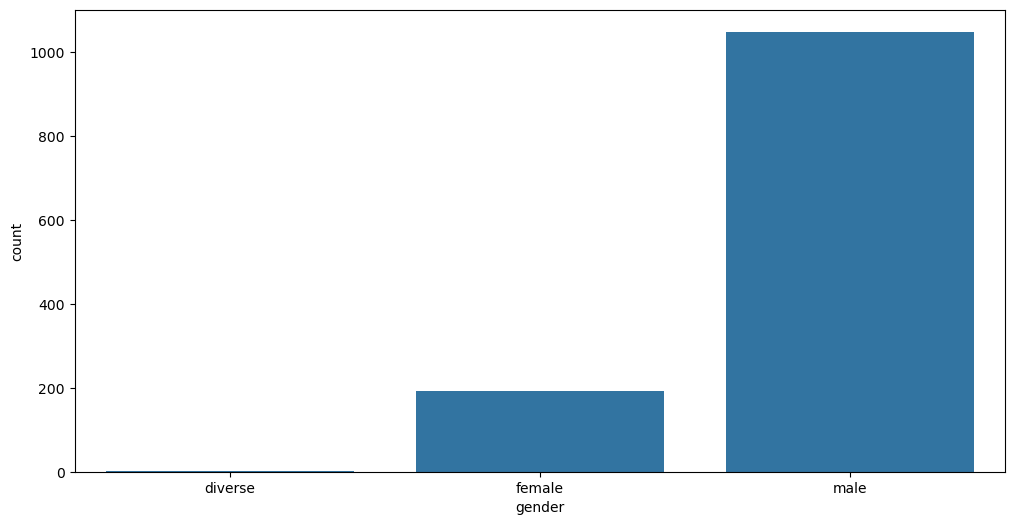

In [ ]:
# Check distribution

sns.countplot(df, x=column);

print(f'Value counts: {df[column].value_counts()}')

##### **Observations**
- males dominate the data
- 'diverse' has too few values for a predictive model to learn from 
    - dropping only 'diverse' values creates some ethical concerns...
    - using gender would probably create more accurate predictions, but might be better off excluding it in the name of fairness
    - drop the column

### **'City'**
- **Inconsistencies:**
    - Countries/regions/etc rather than cities
    - Special characters ex. "()"
    - Invalid answers and extra text ("Prefer not to say", "area", "City in")
    - Abreviations
    - Spelling errors
    - Multiple spellings
- **Actions taken:**
    - Replace inconsistent values using mapping dictionary

In [ ]:
# Basic EDA

column = 'city'
tb.eda_column_summary(df, column)

=== COLUMN: city ===

DTYPE:
category

NON-NULL VALUES:
1,253

NULL VALUES:
0

UNIQUE VALUES:
106

BASIC STATS:
count       1253
unique       106
top       berlin
freq         681
Name: city, dtype: object

TOP VALUES:
city
berlin       681
munich       236
frankfurt     44
hamburg       40
stuttgart     33
Name: count, dtype: int64

BOTTOM VALUES:
city
tampere (finland)    1
warsaw, poland       1
walldorf             1
wroclaw              1
wurzburg             1
Name: count, dtype: int64


In [ ]:
# Import world cities & countries from SimpleMaps

world = pd.read_csv('data/worldcities.csv')   
world = world[['city_ascii', 'country']]

world['city'] = world['city_ascii'].apply(tb.clean_string)
world['country'] = world['country'].apply(tb.clean_string)


In [ ]:
# Compare world cities to df

df['is_valid_city'] = df[column].isin(world['city'])
city_no_match_df = df[df['is_valid_city']==False]
city_no_match_list = city_no_match_df[column].unique().tolist()
city_no_match_df[column].value_counts()

city
nurnberg            4
boeblingen          3
saint-petersburg    2
dusseldurf          1
bolingen            1
                   ..
warsaw              0
wolfsburg           0
wroclaw             0
wurzburg            0
zurich              0
Name: count, Length: 106, dtype: int64

In [ ]:
# Count of unique City values before replacements

city_len_before = len(df[column].unique())
city_len_before

106

In [ ]:
# Convert dtype to string

df[column] = df[column].astype("string")

In [ ]:
# Replace invalid categories and values that are not cities

df[column] = df[column].replace({

    # Not a city, replace with largest city in region or country
    'france': 'paris',              
    'fr': 'paris',                 
    'city in russia': 'moscow',     
    'schleswig-holstein': 'kiel',     # german state
    'konstanz area': 'konstanz',    # region
    'bodensee': 'konstanz',         # lake    
    'nj, usa': 'newark',          
    'prefer not to say': None,
    'moldova': 'chisinau',          

    # Cities with extra text     
    'riga, latvia': 'riga',
    'tampere (finland)': 'tampere',
    'warsaw, poland': 'warsaw',

    # Misspellings or alternate spellings
    'boeblingen': 'boblingen',      # SimpleMaps uses 'Boblingen' (ASCII)
    'bolingen': 'boblingen',
    'nurnberg': 'nuremberg',
    'koln': 'cologne',
    'kiev': 'kyiv',
    'den haag': 'the hague',
    'cracovia': 'krakow',
    'cracow': 'krakow',
    'luttich': 'liege',
    'milano': 'milan',
    'dusseldurf': 'dusseldorf',
    'duesseldorf': 'dusseldorf',
    'saint-petersburg': 'saint petersburg'
})

In [ ]:
# Compare world cities to df again

df['is_valid_city'] = df[column].isin(world['city'])
city_no_match_df = df[df['is_valid_city']==False]
city_no_match_list = city_no_match_df[column].unique().tolist()
city_no_match_df[column].value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
# Compare count of unique City values before and after replacements

city_len_after = len(df[column].unique())

print(f'# of unique values before replacements: {city_len_before}')
print(f'# of unique values after replacements: {city_len_after}')
print(f'Categories removed: {city_len_before-city_len_after}')

# of unique values before replacements: 106
# of unique values after replacements: 91
Categories removed: 15


In [ ]:
# Convert dtype back to category

df[column] = df[column].astype("category")
df[column].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1253 entries, 0 to 1252
Series name: city
Non-Null Count  Dtype   
--------------  -----   
1252 non-null   category
dtypes: category(1)
memory usage: 4.1 KB


In [ ]:
# Add Country feature to df

#CAUTION: MULTIPLE COUNTRIES PER CITY IS CREATING SOME MAPPING ISSUES...

#df = df.merge(
#    world[['city', 'country']], 
#    on='city', 
#    how='left'
#)

In [ ]:
# Drop is_city_valid column

df = df.drop(columns=['is_valid_city'])

##### **Observations**
- invalid entries
    - non cities ex. 'France' and 'Fr' - replace with largest city in area
    - placeholder text ex. 'Prefer not to say' - replace with null
    - added text ex. 'tampere (finland)'  - replace with city only
    - misspelled cities - replace with correct spelling
    - city listed with multiple spellings - select a spelling and replace alternative
- consider adding column for country


### **'Position'**
- **Inconsistencies:**
    - spelling errors
    - different titles with same meaning
    - more than one title listed
    - abreviations
- **Actions taken:**
    - preprocessing: NPL (stop words, lemmatization)
    - encoding: TF-IDF
    - embedding: Word2Vec
    - clustering: KMeans???
    - classification: SVM


In [ ]:
# Basic EDA

column = 'position'
tb.eda_column_summary(df, column)

=== COLUMN: position ===

DTYPE:
category

NON-NULL VALUES:
1,247

NULL VALUES:
6

UNIQUE VALUES:
133

BASIC STATS:
count                  1247
unique                  133
top       software engineer
freq                    387
Name: position, dtype: object

TOP VALUES:
position
software engineer     387
backend developer     174
data scientist        110
frontend developer     89
qa engineer            71
Name: count, dtype: int64

BOTTOM VALUES:
position
testautomation          1
testmanager             1
vp engineering          1
working student (qa)    1
xr developer            1
Name: count, dtype: int64


In [ ]:
sorted(df[column].dropna().unique().tolist())

['account managet',
 'agile coach',
 'agile master',
 'ai management',
 'analyst',
 'analytics engineer',
 'application consultant',
 'architect',
 'backend developer',
 'banker',
 'beikoch',
 'bi analyst',
 'bi consultant',
 'bi consultant sap/ data engineer',
 'bi developer / data engineer',
 'bi it consultant',
 'big data engineer',
 'business analyst',
 'business development manager operations',
 'c/c++/java developer',
 'chief research officer',
 'cloud architect',
 'cloud engineer',
 'computational linguist',
 'computer vision researcher',
 'consultant',
 'consultant data analytics',
 'cto',
 'dana analyst',
 'data analyst',
 'data architect',
 'data center manager',
 'data engineer',
 'data science manager',
 'data scientist',
 'databengineer',
 'dataops team lead',
 'db developer/data analyst',
 'dba',
 'designer (ui/ux)',
 'devops',
 'devops manager',
 'director of engineering',
 'embedded software engineer',
 'engineering manager',
 'engineering team lead',
 'erp consultant',

###  **'Total years of experience'**
- **Inconsistencies:**
    - null values
    - extreme outlier
    - positive skew
    - spikes every 5 year mark (assume rounding)
    - values less than 'years of experience in germany'
- **Actions taken:**
    - convert/replace extreme outlier (383 assumed to be months)
    - impute null values using KNN
    - log transformation
    - standardize column (StandardScaler) or bin values?
    - for values less than 'years of experience in germany', swap values

In [ ]:
# Basic EDA

column = 'total years of experience'
tb.eda_column_summary(df, column)

=== COLUMN: total years of experience ===

DTYPE:
float64

NON-NULL VALUES:
1,230

NULL VALUES:
23

UNIQUE VALUES:
42

BASIC STATS:
count   1,230.00
mean        9.08
std        11.90
min         0.00
25%         5.00
50%         8.00
75%        12.00
max       383.00
Name: total years of experience, dtype: float64

TOP VALUES:
total years of experience
10.00    138
5.00     136
6.00      99
8.00      92
7.00      84
Name: count, dtype: int64

BOTTOM VALUES:
total years of experience
7.50      1
29.00     1
24.00     1
31.00     1
383.00    1
Name: count, dtype: int64


In [ ]:
# Check distribution

df[column].value_counts()

total years of experience
10.00     138
5.00      136
6.00       99
8.00       92
7.00       84
4.00       80
12.00      67
3.00       66
15.00      63
9.00       60
2.00       57
11.00      43
13.00      41
14.00      39
1.00       31
20.00      28
16.00      20
18.00      16
17.00      12
25.00       7
19.00       7
0.00        6
22.00       5
2.50        4
30.00       4
21.00       3
27.00       2
3.50        2
4.50        2
23.00       2
1.50        2
0.80        2
40.00       1
26.00       1
5.50        1
28.00       1
6.50        1
7.50        1
29.00       1
24.00       1
31.00       1
383.00      1
Name: count, dtype: int64

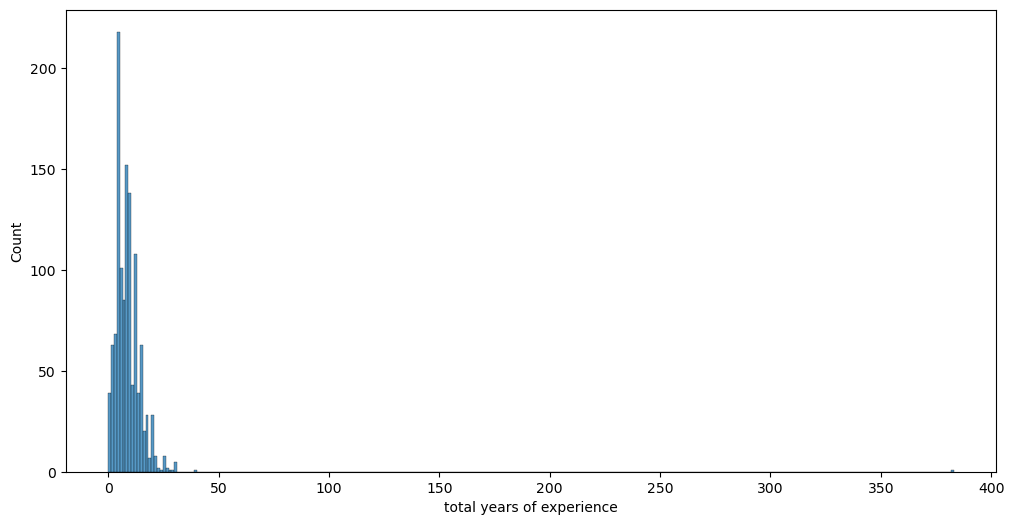

In [ ]:
# Check distribution

sns.histplot(df, x=column);

In [ ]:
# Look at values greater than 40

df[df[column]>40]

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
1103,2020-12-06 21:51:21,69.00,male,stuttgart,rentner,383.00,3.00,head,<NA>,<NA>,"70,000.00",NaN,NaN,<NA>,<NA>,german,11-50,consulting / agency,NaN


In [ ]:
# Convert extreme value to months

383/12

31.916666666666668

32 years seems reasonable

In [ ]:
# Replace value

df.loc[1103, column] = 32

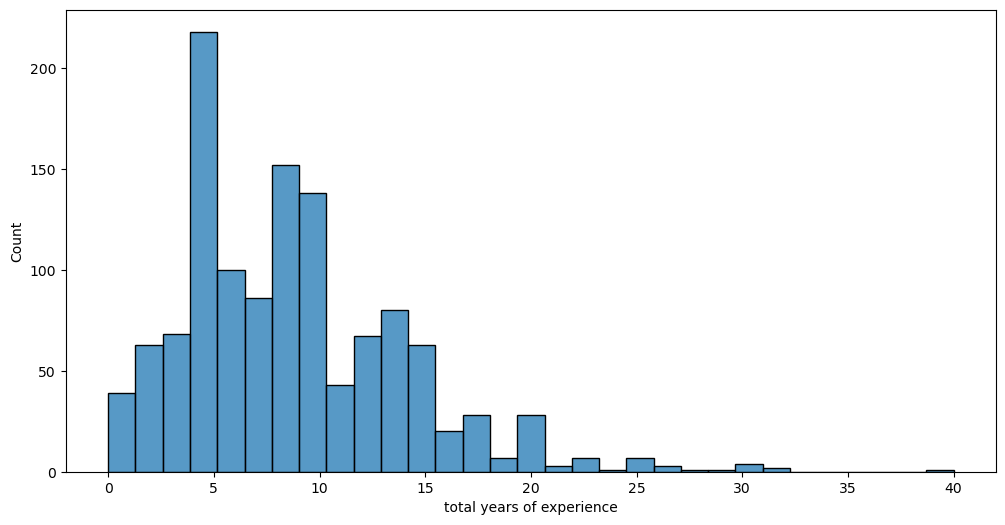

In [ ]:
# Check distribution again

sns.histplot(df, x=column);

In [ ]:
# Total Experience should be greater than German Experience. Check for values that are less than German Experience

mask = df['years of experience in germany'] > df[column]

df[mask]

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
318,2020-11-24 17:03:03,33.00,diverse,hamburg,software engineer,1.00,6.00,middle,scala,"python, sql, kubernetes, docker","130,000.00",0.00,NaN,full-time employee,unlimited contract,english,1000+,product,"130,000.00"
339,2020-11-24 17:39:35,28.00,male,munich,software engineer,5.00,6.00,senior,c++,"python, c/c++","67,000.00","2,000.00",20.00,self-employed (freelancer),unlimited contract,english,up to 10,startup,"69,000.00"
509,2020-11-25 09:40:44,36.00,female,berlin,devops,1.00,3.00,middle,java,"kubernetes, docker","60,000.00","5,000.00",26.00,full-time employee,unlimited contract,english,51-100,consulting / agency,"65,000.00"
701,2020-11-25 21:05:06,43.00,male,berlin,devops,21.00,26.00,lead,<NA>,"python, php, sql, perl, aws, google cloud, kub...","83,000.00",NaN,28.00,full-time employee,unlimited contract,german,51-100,startup,NaN
848,2020-11-27 14:34:16,NaN,female,berlin,data scientist,1.00,8.00,junior,python,"python, r, sql, azure","55,000.00",NaN,30.00,full-time employee,unlimited contract,english,1000+,product,NaN
920,2020-11-30 10:48:04,28.00,male,berlin,ml engineer,0.00,1.00,junior,python,"python, docker","48,000.00",NaN,30.00,full-time employee,unlimited contract,english,11-50,startup,NaN
962,2020-11-30 13:52:05,36.00,male,hamburg,data scientist,2.00,10.00,middle,python,"java / scala, sql","63,000.00",NaN,30.00,full-time employee,unlimited contract,english,11-50,product,NaN
1098,2020-12-06 14:46:17,32.00,male,berlin,designer (ui/ux),5.00,10.00,senior,java,"python, php, javascript / typescript, sql","70,000.00","5,000.00",24.00,self-employed (freelancer),unlimited contract,german,up to 10,startup,"75,000.00"
1123,2020-12-08 08:17:39,27.00,male,munich,software engineer,2.00,5.00,junior,java,javascript / typescript,"68,000.00","2,000.00",28.00,full-time employee,unlimited contract,english,101-1000,product,"70,000.00"


Most records look like they've reversed total experience and german experience

In [ ]:
# Swap total experience with german experience

df.loc[mask, [column, 'years of experience in germany']] = df.loc[mask, ['years of experience in germany', column]].values

In [ ]:
# Check that swap worked

mask = df['years of experience in germany'] > df[column]

df[mask]

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation


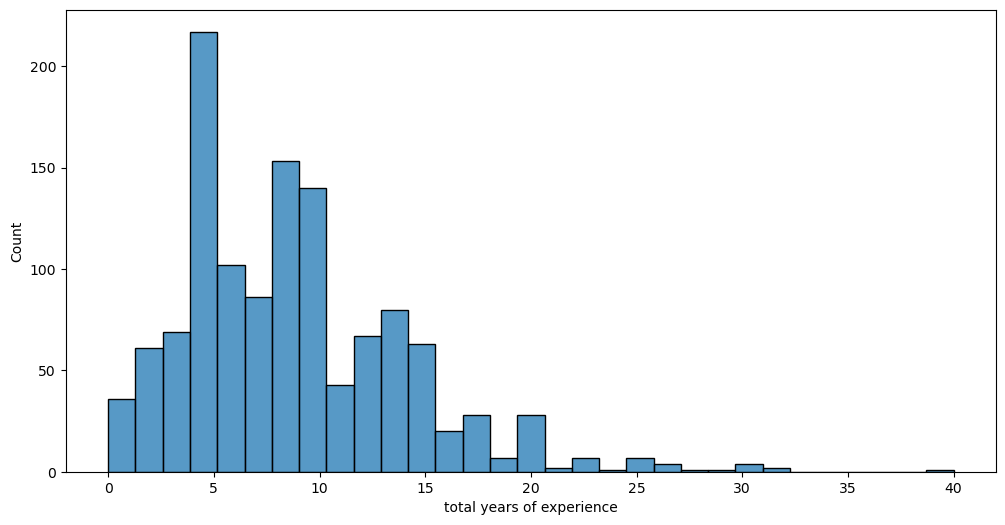

In [ ]:
# Check distribution one more time

sns.histplot(df, x=column);

###  **'Years of experience in Germany'**
- **Inconsistencies:**
    - null values
    - positive skew
    - records with total experience less than german experience
- **Actions taken:**
    - impute nulls using KNN
    - log transform data
    - swap total experience with german experience (completed in total experience section)

In [ ]:
# Basic EDA

column = 'years of experience in germany'
tb.eda_column_summary(df, column)

=== COLUMN: years of experience in germany ===

DTYPE:
float64

NON-NULL VALUES:
1,195

NULL VALUES:
58

UNIQUE VALUES:
36

BASIC STATS:
count   1,195.00
mean        3.72
std         3.63
min         0.00
25%         1.00
50%         3.00
75%         5.00
max        30.00
Name: years of experience in germany, dtype: float64

TOP VALUES:
years of experience in germany
2.00    197
1.00    191
3.00    154
5.00    143
4.00    122
Name: count, dtype: int64

BOTTOM VALUES:
years of experience in germany
21.00    1
4.50     1
0.10     1
2.60     1
0.20     1
Name: count, dtype: int64


In [ ]:
# Check distribution

df[column].value_counts()


years of experience in germany
2.00     197
1.00     191
3.00     154
5.00     143
4.00     122
0.00     101
6.00      68
7.00      37
10.00     27
1.50      24
9.00      20
8.00      16
0.50      13
12.00     12
2.50      10
3.50       9
15.00      8
20.00      7
11.00      7
14.00      5
13.00      4
30.00      3
0.25       2
18.00      2
19.00      2
0.40       1
0.90       1
0.80       1
25.00      1
16.00      1
17.00      1
21.00      1
4.50       1
0.10       1
2.60       1
0.20       1
Name: count, dtype: int64

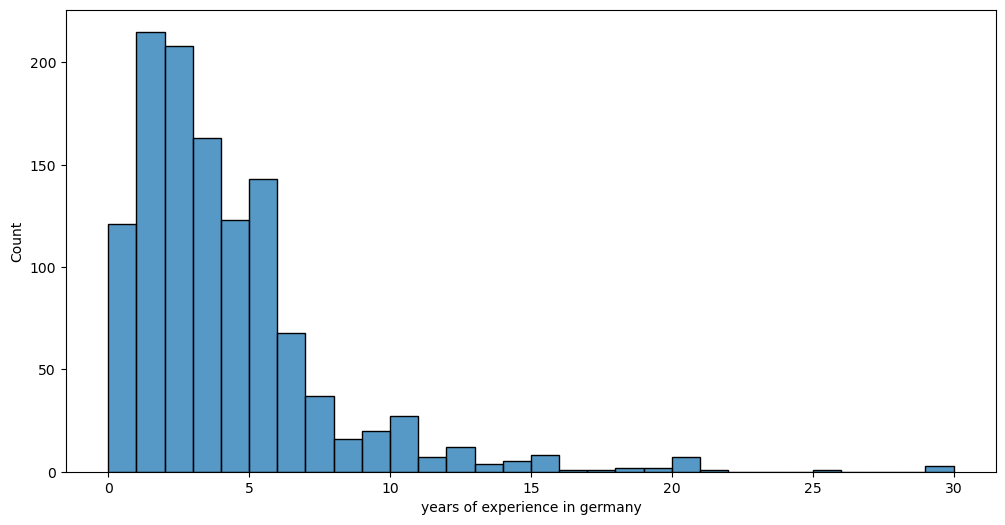

In [ ]:
# Check distribution

sns.histplot(df, x=column, bins=30);

In [ ]:
# There sure are a lot of zeros...

df[df[column]==0].sample(10)

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
777,2020-11-26 16:20:53,29.00,male,helsinki,mobile developer,7.00,0.00,senior,kotlin,"javascript / typescript, java / scala, flutter","64,000.00","1,100.00",30.00,full-time employee,unlimited contract,english,51-100,consulting / agency,"65,100.00"
444,2020-11-24 21:39:12,24.00,male,tallinn,software engineer,3.00,0.00,junior,java,"python, sql","30,000.00",0.00,28.00,full-time employee,unlimited contract,english,11-50,product,"30,000.00"
569,2020-11-25 12:47:31,28.00,male,berlin,product manager,7.00,0.00,head,<NA>,<NA>,"60,000.00","9,000.00",28.00,full-time employee,unlimited contract,english,101-1000,product,"69,000.00"
455,2020-11-24 22:28:07,30.00,male,moscow,backend developer,2.00,0.00,junior,elixir,<NA>,"50,000.00","55,000.00",30.00,self-employed (freelancer),unlimited contract,english,101-1000,product,"105,000.00"
1168,2020-12-17 10:28:18,40.00,male,berlin,data engineer,14.00,0.00,middle,"bi, dwh, etl/elt","python, sql, ms sql stack, oracle, informatica...","57,000.00","3,000.00",24.00,full-time employee,unlimited contract,english,101-1000,product,"60,000.00"
1217,2021-01-01 13:40:08,34.00,male,prague,backend developer,14.00,0.00,lead,c#,"javascript / typescript, .net, azure, kubernet...","90,000.00","40,000.00",30.00,full-time employee,unlimited contract,english,1000+,product,"130,000.00"
360,2020-11-24 18:16:39,25.00,male,berlin,backend developer,5.00,0.00,senior,java,python,"60,000.00","5,600.00",NaN,<NA>,<NA>,<NA>,<NA>,<NA>,"65,600.00"
167,2020-11-24 12:23:06,28.00,male,chisinau,backend developer,4.00,0.00,middle,java,"kotlin, java / scala","28,000.00",NaN,NaN,<NA>,<NA>,english,51-100,startup,NaN
927,2020-11-30 11:06:44,25.00,male,stuttgart,data scientist,0.00,0.00,junior,python,"r, sql, hadoop hive","58,000.00",NaN,30.00,full-time employee,unlimited contract,german,1000+,handel,NaN
857,2020-11-27 15:49:51,31.00,male,amsterdam,data scientist,10.00,0.00,lead,python,"javascript / typescript, r, sql, aws, azure, d...","100,000.00","20,000.00",30.00,full-time employee,unlimited contract,english,11-50,product,"120,000.00"


I guess it's possible to have that many zeros... And it fits the distribution.

###  **'Seniority level'**
- **Inconsistencies:**
    - null values
    - non-standardized categories
- **Actions taken:**
    - impute null values
    - manually standardize categories

In [ ]:
# Basic EDA

column = 'seniority level'
tb.eda_column_summary(df, column)

=== COLUMN: seniority level ===

DTYPE:
category

NON-NULL VALUES:
1,241

NULL VALUES:
12

UNIQUE VALUES:
21

BASIC STATS:
count       1241
unique        21
top       senior
freq         565
Name: seniority level, dtype: object

TOP VALUES:
seniority level
senior    565
middle    366
lead      166
junior     79
head       44
Name: count, dtype: int64

BOTTOM VALUES:
seniority level
manager                1
self employed          1
vp                     1
work center manager    1
working student        1
Name: count, dtype: int64


In [ ]:
df[column].unique().tolist()

['senior',
 'lead',
 'junior',
 'middle',
 'head',
 <NA>,
 'no level',
 'vp',
 'manager',
 'work center manager',
 'cto',
 'director',
 'key',
 'c-level executive manager',
 'principal',
 'intern',
 'student',
 'no idea, there are no ranges in the firm',
 'c-level',
 'working student',
 'entry level',
 'self employed']

In [ ]:
# Convert dtype to string

df[column] = df[column].astype("string")

In [ ]:
# Standardize categories

df[column] = df[column].replace({
    'senior': 'SENIOR',
    'lead': 'MANAGER',
    'junior': 'JUNIOR',
    'middle': 'MID',
    'head': 'DIRECTOR',
    None: 'NO_LEVEL',
    'no level': 'NO_LEVEL',
    'vp': 'EXECUTIVE',
    'manager': 'MANAGER',
    'work center manager': 'MANAGER',
    'cto': 'EXECUTIVE',
    'director': 'DIRECTOR',
    'key': 'MANAGER',
    'c-level executive manager': 'EXECUTIVE',
    'principal': 'MANAGER',
    'intern': 'JUNIOR',
    'student': 'JUNIOR',
    'no idea, there are no ranges in the firm': 'NO_LEVEL',
    'c-level': 'EXECUTIVE',
    'working student': 'JUNIOR',
    'entry level': 'JUNIOR',
    'self employed': 'SELF_EMPLOYED'
}).fillna('NO_LEVEL')

In [ ]:
# Convert dtype back to category

df[column] = df[column].astype("category")
df[column].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1253 entries, 0 to 1252
Series name: seniority level
Non-Null Count  Dtype   
--------------  -----   
1253 non-null   category
dtypes: category(1)
memory usage: 1.7 KB


In [ ]:
df[column].value_counts()

seniority level
SENIOR           565
MID              366
MANAGER          172
JUNIOR            85
DIRECTOR          45
NO_LEVEL          15
EXECUTIVE          4
SELF_EMPLOYED      1
Name: count, dtype: int64

In [ ]:
# Create ranking map for standardized categories and add column

seniority_rank = {
    'NO_LEVEL': 0,
    'JUNIOR': 1,
    'MID': 2,
    'SENIOR': 3,
    'MANAGER': 4,
    'DIRECTOR': 5,
    'EXECUTIVE': 6,
    'SELF_EMPLOYED': 7
}

df['seniority rank'] = df[column].map(seniority_rank).astype(int)
df.head(3)

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation,seniority rank
0,2020-11-24 11:14:15,26.00,male,munich,software engineer,5.00,3.00,SENIOR,typescript,"kotlin, javascript / typescript","80,000.00","5,000.00",30.00,full-time employee,unlimited contract,english,51-100,product,"85,000.00",3
1,2020-11-24 11:14:16,26.00,male,berlin,backend developer,7.00,4.00,SENIOR,ruby,<NA>,"80,000.00",NaN,28.00,full-time employee,unlimited contract,english,101-1000,product,NaN,3
2,2020-11-24 11:14:21,29.00,male,berlin,software engineer,12.00,6.00,MANAGER,javascript / typescript,"javascript / typescript, docker","120,000.00","120,000.00",30.00,self-employed (freelancer),temporary contract,english,101-1000,product,"240,000.00",4


Value counts: seniority rank
3    565
2    366
4    172
1     85
5     45
0     15
6      4
7      1
Name: count, dtype: int64


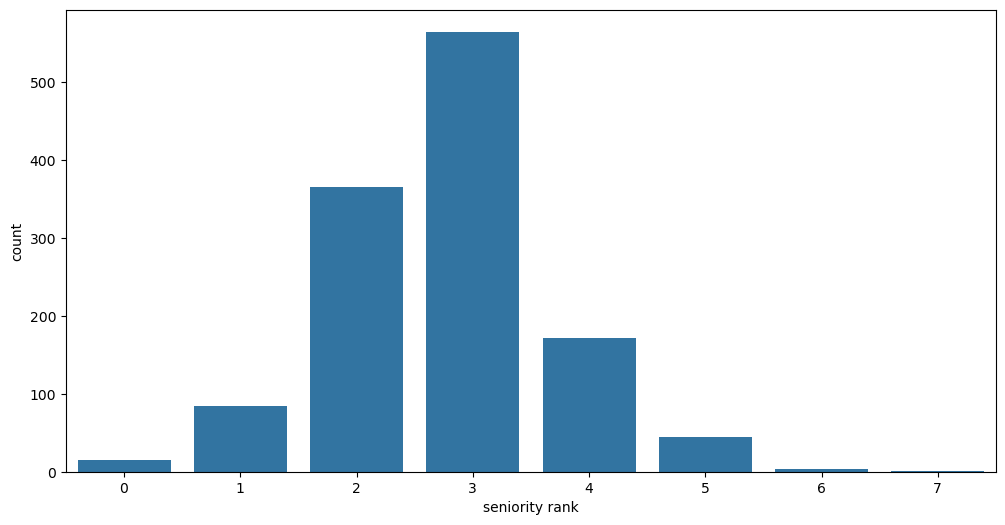

In [ ]:
# Check distribution

sns.countplot(df, x='seniority rank');

print(f"Value counts: {df['seniority rank'].value_counts()}")


###  **'Your main technology / programming language'** COME BACK TO THIS
- **Inconsistencies:**
    - null values
    - non-standardized categories
    - multiple values per record
    - different spellings
- **Actions taken:**
    - impute nulls using KNN
    - standardize with Word2Vec?

In [ ]:
df.columns

Index(['timestamp', 'age', 'gender', 'city', 'position',
       'total years of experience', 'years of experience in germany',
       'seniority level', 'your main technology / programming language',
       'other technologies/programming languages you use often',
       'yearly brutto salary (without bonus and stocks) in eur',
       'yearly bonus + stocks in eur', 'number of vacation days',
       'employment status', 'contract duration', 'main language at work',
       'company size', 'company type', 'total_compensation', 'seniority rank'],
      dtype='object', name='Column')

In [ ]:
# Basic EDA

column = 'your main technology / programming language'

tb.eda_column_summary(df, column)

=== COLUMN: your main technology / programming language ===

DTYPE:
category

NON-NULL VALUES:
1,125

NULL VALUES:
128

UNIQUE VALUES:
206

BASIC STATS:
count       1125
unique       206
top       python
freq         212
Name: your main technology / programming language, dtype: object

TOP VALUES:
your main technology / programming language
python        212
java          196
javascript     80
php            71
c++            41
Name: count, dtype: int64

BOTTOM VALUES:
your main technology / programming language
typescript/angular    1
vb, rpa, python       1
vhdl                  1
web                   1
web developer         1
Name: count, dtype: int64


In [ ]:
'''main_skills = 'your main technology / programming language'
other_skills = 'other technologies/programming languages you use often'

df_skills[['main_skills', 'other_skills']] = df[[main_skills, other_skills]].astype("string")


skills_raw = (
    df['your main technology / programming language'] + ',' +
    df['other technologies/programming languages you use often']
)

# Clean separators
skills_clean = (
    skills_raw
    .str.replace('/', ',', regex=False)
    .str.replace(';', ',', regex=False)
    .str.replace('+', ',', regex=False)    
    .str.replace('&', ',', regex=False)    
)

df['skills_lists'] = skills_clean.str.split(',')'''


'main_skills = \'your main technology / programming language\'\nother_skills = \'other technologies/programming languages you use often\'\n\ndf_skills[[\'main_skills\', \'other_skills\']] = df[[main_skills, other_skills]].astype("string")\n\n\nskills_raw = (\n    df[\'your main technology / programming language\'] + \',\' +\n    df[\'other technologies/programming languages you use often\']\n)\n\n# Clean separators\nskills_clean = (\n    skills_raw\n    .str.replace(\'/\', \',\', regex=False)\n    .str.replace(\';\', \',\', regex=False)\n    .str.replace(\'+\', \',\', regex=False)    \n    .str.replace(\'&\', \',\', regex=False)    \n)\n\ndf[\'skills_lists\'] = skills_clean.str.split(\',\')'

In [ ]:
df['skills_lists']

KeyError: 'skills_lists'

In [ ]:
#sorted(df['skills_lists'].dropna().unique().tolist())

In [ ]:
# Standardize descriptions (thank-you Copilot!)

skill_normalization = {
    # Noise / empty
    "": None,
    "-": None,
    "nothing": None,
    "several": None,

    # Shell / scripting
    "*shell(s) scripts": "shell scripting",
    "shell": "shell scripting",
    "unix shell scripts": "shell scripting",

    # .NET family
    ".net": "dotnet",
    ".net core": "dotnet",
    "c# .net": "c#",
    "vb.net": "vb",

    # Programming languages
    "c": "c",
    "c++": "c++",
    "c#": "c#",
    "pascal": "pascal",
    "perl": "perl",
    "php": "php",
    "python": "python",
    "pythin": "python",
    "pyrhon": "python",
    "python (django)": "python",
    "python + sql": "python",
    "r": "r",
    "ruby": "ruby",
    "ruby on rails": "ruby on rails",
    "rust": "rust",
    "scala": "scala",
    "scala spark": "scala",
    "haskell": "haskell",
    "julia": "julia",
    "java": "java",
    "java backend": "java",
    "java & php": "java",
    "java & distributed systems stuff": "java",
    "javscript": "javascript",
    "javascript": "javascript",
    "javascript (react)": "javascript",
    "js": "javascript",
    "ts": "typescript",
    "typescript": "typescript",
    "dart": "dart",

    # Web frameworks / frontend
    "react": "react",
    "react js": "react",
    "react.js": "react",
    "reactjs": "react",
    "frontend": "frontend",
    "frontend: react": "react",
    "web apps": "web",
    "web developer": "web",

    # Mobile
    "android": "android",
    "ios": "ios",
    "objective c": "objective-c",
    "objective-c": "objective-c",
    "swift": "swift",
    "flutter": "flutter",

    # Cloud
    "aws": "aws",
    "aws hadoop postgre typescript": "aws"
    "azure": "azure",
    "gcp": "gcp",
    "google cloud": "gcp",
    "google cloud platform": "gcp",
    "cloud": "cloud",
    "cloud computing": "cloud",
    "clouds": "cloud",

    # DevOps / Infra
    "k8s": "kubernetes",
    "kuberenetes": "kubernetes",
    "kubrrnetes": "kubernetes",
    "kubernetes": "kubernetes",
    "docker": "docker",
    "jenkins bash": "jenkins",
    "jenkins": "jenkins",
    "bash": "bash",
    "powershell": "powershell",
    "ansible": "ansible",
    "puppet": "puppet",
    "terraform": "terraform",
    "openstack": "openstack",
    "virtualisation platforms": "virtualization",
    "unix": "unix",
    "linux": "linux",
    "linux kernel": "linux",
    "helm": "helm",
    "kustomize": "kustomize",
    "packer": "packer",
    "nomad": "nomad",
    "vms": "vms",

    # Data / ML / Analytics
    "sql": "sql",
    "pl": "pl/sql",
    "postgres": "postgresql",
    "postgresql": "postgresql",
    "mysql": "mysql",
    "mongo": "mongodb",
    "mongodb": "mongodb",
    "ms sql stack": "sql",
    "bq": "bigquery",
    "etl": "etl",
    "elt": "etl",
    "dwh": "data warehouse",
    "bi": "business intelligence",
    "qlik": "qlik",
    "qlik bi tool": "qlik",
    "qliksense": "qliksense",
    "power bi": "power bi",
    "tableau": "tableau",
    "statistics": "statistics",
    "ml": "machine learning",
    "nlp": "nlp",
    "pytorch": "pytorch",
    "tensorflow": "tensorflow",
    "theano": "theano",
    "apache hadoop": "hadoop",
    "apache hive": "hive",
    "apache impala": "impala",
    "apache spark": "spark",
    "spark": "spark",
    "hadoop hive": "hive", "hadoop"
    "whole apache data science stack": "apache stack",
    "plotly dash": "plotly dash",

    # Networking
    "networking": "networking",
    "network security": "network security",
    "network automation": "network automation",
    "computer networking": "networking",
    "data center": "data center",

    # Enterprise / Business
    "sap": "sap",
    "sap abap": "abap",
    "sap bw": "sap bw",
    "abap": "abap",
    "salesforce": "salesforce",
    "jira": "jira",
    "atlassian jira": "jira",
    "automation": "automation",
    "autonomous driving": "autonomous driving",
    "pegasystems platform": "pegasystems",
    "informatica powercenter": "informatica",
    "business development manager operation": "business development",

    # Design / UX
    "adobe xd": "adobe xd",
    "css": "css",
    "css3": "css",
    "html": "html",
    "sketch": "sketch",
    "ps": "photoshop",
    "tailwindcss": "tailwindcss",

    # QA / Testing
    "qa": "qa",
    "squish": "squish",
    "wdio": "webdriverio",
    "tricentis tosca": "tosca",
    "test management": "test management",

    # Misc tech
    "assembly": "assembly",
    "clojure": "clojure",
    "cobol": "cobol",
    "delphi": "delphi",
    "elixir": "elixir",
    "erlang": "erlang",
    "fbd": "fbd",
    "grails": "grails",
    "graphql": "graphql",
    "groovy": "groovy",
    "gtm": "gtm",
    "helm": "helm",
    "kustomize": "kustomize",
    "magento": "magento",
    "matlab": "matlab",
    "qml": "qml",
    "qt": "qt",
    "quorum": "quorum",
    "rpa": "rpa",
    "spss": "spss",
    "spring": "spring",
    "sre": "sre",
    "vhdl": "vhdl",
    "yaml": "yaml",
}

SyntaxError: ':' expected after dictionary key (2440020512.py, line 73)

In [ ]:
# Explode skills_lists into rows

df_exploded = df.explode('skills_lists')
df_exploded['skills_lists'] = df_exploded['skills_lists'].str.strip()

In [ ]:
df_exploded['skills_lists'] = df_exploded['skills_lists'].map(skill_normalization)

In [ ]:
#sorted(df_exploded['skills_lists'].dropna().unique().tolist())

In [ ]:
# Encode the exploded 'skills_lists' & filter for skills with counts greater than 2

skills_dummies = pd.get_dummies(df_exploded['skills_lists'])
skills_encoded = skills_dummies.groupby(df_exploded.index).max()
skill_counts = skills_encoded.sum().sort_values(ascending=False)
cols_to_keep = skill_counts[skill_counts > 2].index
skills_encoded = skills_encoded[cols_to_keep]

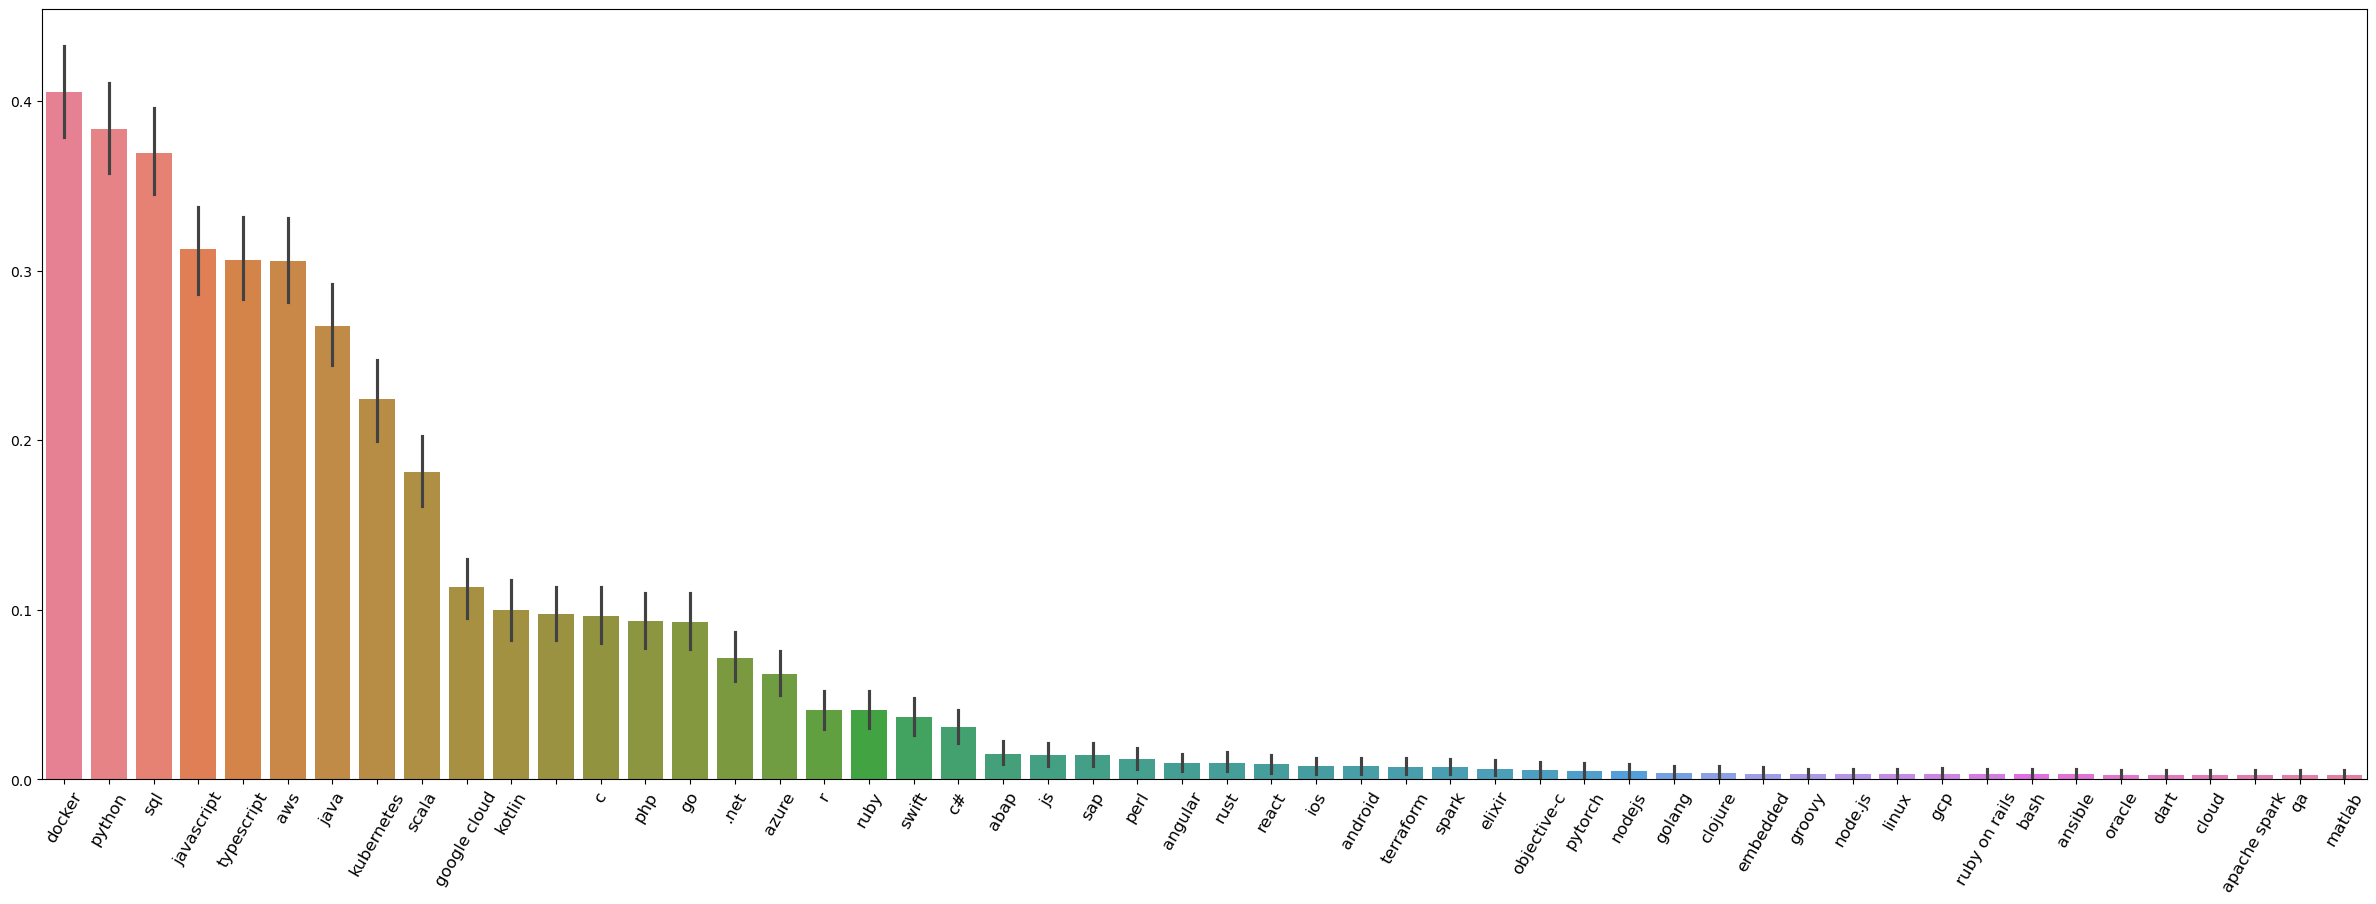

In [ ]:
# Check counts

plt.figure(figsize=(30, 10))
sns.barplot(skills_encoded)
plt.xticks(rotation=60, fontsize=12);

In [ ]:
df.head()

,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,seniority rank,skills_lists,abap,adobe xd,android,ansible,apache stack,assembly,automation,autonomous driving,aws,azure,bash,bigquery,business intelligence,c,c#,c++,clojure,cloud,cobol,css,dart,data center,data warehouse,delphi,docker,dotnet,elixir,erlang,etl,fbd,flutter,frontend,gcp,grails,graphql,groovy,gtm,hadoop,haskell,helm,hive,html,impala,informatica,ios,java,javascript,jenkins,jira,julia,kubernetes,kustomize,linux,machine learning,magento,matlab,mongodb,mysql,network automation,network security,networking,nlp,nomad,objective-c,openstack,packer,pascal,pegasystems,perl,photoshop,php,pl/sql,plotly dash,postgresql,power bi,powershell,puppet,python,pytorch,qa,qlik,qliksense,qml,qt,quorum,r,react,rpa,ruby,ruby on rails,rust,salesforce,sap,sap bw,scala,shell scripting,sketch,spark,spring,spss,sql,squish,sre,statistics,swift,tableau,tailwindcss,tensorflow,terraform,theano,tosca,typescript,unix,vb,vhdl,virtualization,vms,web,webdriverio,yaml
0,2020-11-24 11:14:15,26.00,male,munich,software engineer,5.00,3.00,SENIOR,typescript,"kotlin, javascript / typescript","80,000.00","5,000.00",30.00,full-time employee,unlimited contract,english,51-100,product,3,"[typescript, kotlin, javascript , typescript]",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,2020-11-24 11:14:16,26.00,male,berlin,backend developer,7.00,4.00,SENIOR,ruby,<NA>,"80,000.00",NaN,28.00,full-time employee,unlimited contract,english,101-1000,product,3,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2020-11-24 11:14:21,29.00,male,berlin,software engineer,12.00,6.00,MANAGER,javascript / typescript,"javascript / typescript, docker","120,000.00","120,000.00",30.00,self-employed (freelancer),temporary contract,english,101-1000,product,4,"[javascript , typescript, javascript , types...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [ ]:
df = df.join(skills_encoded)
df.head()

###  **'Other technologies/programming languages you use often'** COME BACK TO THIS
- **Inconsistencies:**
    - 
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Other technologies/programming languages you use often')

KeyError: 'Other technologies/programming languages you use often'

###  **'Yearly brutto salary (without bonus and stocks) in EUR'**
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

- consider dropping ind #1181

In [ ]:
# Basic EDA

column = 'yearly brutto salary (without bonus and stocks) in eur'

tb.eda_column_summary(df, column)

=== COLUMN: yearly brutto salary (without bonus and stocks) in eur ===

DTYPE:
float64

NON-NULL VALUES:
1,253

NULL VALUES:
0

UNIQUE VALUES:
201

BASIC STATS:
count            1,253.00
mean        80,279,042.58
std      2,825,061,107.59
min             10,001.00
25%             58,800.00
50%             70,000.00
75%             80,000.00
max     99,999,999,999.00
Name: yearly brutto salary (without bonus and stocks) in eur, dtype: float64

TOP VALUES:
yearly brutto salary (without bonus and stocks) in eur
60,000.00    85
70,000.00    83
65,000.00    77
75,000.00    73
80,000.00    66
Name: count, dtype: int64

BOTTOM VALUES:
yearly brutto salary (without bonus and stocks) in eur
68,250.00     1
84,700.00     1
50,500.00     1
108,500.00    1
38,350.00     1
Name: count, dtype: int64


In [ ]:
# Look at top salaries

df.nlargest(5, column)

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
473,25/11/2020 03:27:34,NaN,<NA>,berlin,<NA>,NaN,NaN,<NA>,<NA>,<NA>,"99,999,999,999.00",NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
853,27/11/2020 14:55:13,29.00,female,cologne,ml engineer,1.00,1.00,middle,julia,<NA>,"500,000,000.00","5,000,000,000.00",99.00,full-time employee,unlimited contract,english,up to 10,startup,"5,500,000,000.00"
778,26/11/2020 17:08:47,42.00,male,berlin,frontend developer,18.00,5.00,senior,react js,javascript / typescript,"850,000.00","95,000.00",35.00,full-time employee,unlimited contract,english,101-1000,product,"945,000.00"
576,25/11/2020 13:26:21,24.00,male,munich,data scientist,1.00,1.00,junior,c++,"python, c/c++, swift, java / scala, r, sql, go...","300,000.00",NaN,NaN,full-time employee,<NA>,english,101-1000,startup,NaN
630,25/11/2020 15:53:21,40.00,male,cupertino,software engineer,20.00,0.00,lead,swift,<NA>,"250,000.00","450,000.00",45.00,full-time employee,unlimited contract,english,1000+,product,"700,000.00"


- index 473: DROP - no usable data
- index 853: DROP - salary & bonus not usable, errors in other fields
- index 576: looks kinda sus but keep

In [ ]:
# Check 
df.loc[[1181]]

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
1181,20/12/2020 00:31:23,NaN,<NA>,berlin,<NA>,NaN,NaN,<NA>,<NA>,<NA>,"111,111.00",NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN


In [ ]:
rows = [473, 853]

###  **'Yearly bonus + stocks in EUR'**
- **Inconsistencies:**
    - lots of null values
    - zero values (but those might make sense)
    - extreme outliers (who is paying $5B bonuses?!)
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

column = 'yearly bonus + stocks in eur'

tb.eda_column_summary(df, column)

=== COLUMN: yearly bonus + stocks in eur ===

DTYPE:
float64

NON-NULL VALUES:
823

NULL VALUES:
430

UNIQUE VALUES:
162

BASIC STATS:
count             823.00
mean        6,096,870.48
std       174,288,300.19
min                 0.00
25%                 0.00
50%             5,000.00
75%            20,000.00
max     5,000,000,000.00
Name: yearly bonus + stocks in eur, dtype: float64

TOP VALUES:
yearly bonus + stocks in eur
0.00         227
5,000.00      56
10,000.00     45
2,000.00      36
6,000.00      26
Name: count, dtype: int64

BOTTOM VALUES:
yearly bonus + stocks in eur
110,000.00    1
700.00        1
16,320.00     1
105,000.00    1
40,950.00     1
Name: count, dtype: int64


In [ ]:
df.loc[df[column]==df[column].max()]

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation,seniority rank
853,2020-11-27 14:55:13,29.00,female,cologne,ml engineer,1.00,1.00,MID,julia,<NA>,"500,000,000.00","5,000,000,000.00",99.00,full-time employee,unlimited contract,english,up to 10,startup,"5,500,000,000.00",2


In [ ]:
# Look at the biggest values first (top 90%)

cutoff = df[column].quantile(0.95)
df[df[column]>=cutoff]


Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation,seniority rank
2,2020-11-24 11:14:21,29.00,male,berlin,software engineer,12.00,6.00,MANAGER,javascript / typescript,"javascript / typescript, docker","120,000.00","120,000.00",30.00,self-employed (freelancer),temporary contract,english,101-1000,product,"240,000.00",4
220,2020-11-24 13:32:34,36.00,male,berlin,engineering manager,7.00,1.00,MANAGER,"swift, objective-c","kotlin, swift, go, aws, kubernetes, docker","80,000.00","95,000.00",26.00,full-time employee,unlimited contract,english,1000+,product,"175,000.00",4
235,2020-11-24 13:55:19,32.00,male,berlin,engineering manager,9.00,5.00,MANAGER,<NA>,"php, javascript / typescript, .net, sql, googl...","95,000.00","140,000.00",365.00,full-time employee,unlimited contract,english,1000+,product,"235,000.00",4
248,2020-11-24 14:13:21,38.00,male,frankfurt,tech lead,16.00,1.00,MANAGER,.net,"javascript / typescript, .net, sql, aws, azure...","99,000.00","112,000.00",25.00,full-time employee,<NA>,english,101-1000,fintech,"211,000.00",4
279,2020-11-24 15:05:21,39.00,male,berlin,product manager,10.00,5.00,MANAGER,<NA>,<NA>,"120,000.00","200,000.00",25.00,full-time employee,unlimited contract,english,1000+,product,"320,000.00",4
434,2020-11-24 21:10:08,32.00,male,munich,software engineer,10.00,6.00,SENIOR,java,"javascript / typescript, go","88,000.00","120,000.00",30.00,full-time employee,unlimited contract,english,1000+,product,"208,000.00",3
441,2020-11-24 21:36:24,32.00,male,berlin,cto,10.00,4.00,EXECUTIVE,java,"python, c/c++","200,000.00","200,000.00",28.00,full-time employee,unlimited contract,english,101-1000,product,"400,000.00",6
449,2020-11-24 22:04:32,46.00,male,frankfurt,software engineer,23.00,16.00,SENIOR,c#,"c/c++, javascript / typescript, .net, sql, azure","90,000.00","96,000.00",30.00,full-time employee,unlimited contract,german,1000+,consulting / agency,"186,000.00",3
494,2020-11-25 09:00:23,39.00,male,berlin,manager,11.00,9.00,DIRECTOR,python,"python, kotlin, java / scala, aws","180,000.00","150,000.00",28.00,full-time employee,unlimited contract,english,1000+,product,"330,000.00",5
497,2020-11-25 09:05:26,38.00,male,berlin,data scientist,15.00,2.00,DIRECTOR,python,"python, sql, sap / abap, aws","100,000.00","120,000.00",27.00,full-time employee,unlimited contract,english,101-1000,startup,"220,000.00",5


In [ ]:
# Check distribution

sns.histplot(df[column].dropna());


KeyboardInterrupt: 

###  **'Number of vacation days'**
- **Inconsistencies:**
    - null values
    - zero values (pretty sure that's illegal...)
    - values less than 20 (EU min in 20 days/4 weeks, other countries vary)
    - extreme outliers
    - positive skew
    - spike at 30
- **Actions taken:**
    - assume values less than or equal to 10 are weeks, not days
        - multipy by 5
    - after weeks-to-days conversion, replace values still less than 20 with null
    - replace zeros with null 
    - replace >50 with null
    - impute nulls
    - log transformation
    - standardize?

In [ ]:
# Basic EDA

column = 'number of vacation days'

tb.eda_column_summary(df, column)

=== COLUMN: number of vacation days ===

DTYPE:
float64

NON-NULL VALUES:
1,172

NULL VALUES:
81

UNIQUE VALUES:
36

BASIC STATS:
count   1,172.00
mean       28.35
std        10.76
min         0.00
25%        27.00
50%        28.00
75%        30.00
max       365.00
Name: number of vacation days, dtype: float64

TOP VALUES:
number of vacation days
30.00    488
28.00    233
27.00    102
25.00     91
26.00     71
Name: count, dtype: int64

BOTTOM VALUES:
number of vacation days
5.00     1
37.00    1
39.00    1
34.00    1
10.00    1
Name: count, dtype: int64


In [ ]:
# Check distribution

df[column].value_counts().sort_index()


number of vacation days
0.00        4
1.00        1
3.00        1
5.00        1
10.00       1
12.00       2
14.00       3
15.00       2
16.00       1
20.00      13
21.00      10
22.00       8
23.00       4
24.00      67
25.00      91
26.00      71
27.00     102
28.00     233
29.00      24
30.00     488
31.00       8
32.00       8
33.00       3
34.00       1
35.00       5
36.00       5
37.00       1
37.50       1
38.00       1
39.00       1
40.00       4
45.00       3
50.00       1
60.00       1
99.00       1
365.00      1
Name: count, dtype: int64

In [ ]:
# Check values less than 10 days

df[df[column]<10].sort_values(by='city')[[column, 'city']]

Column,number of vacation days,city
574,0.00,berlin
641,0.00,berlin
971,5.00,berlin
960,1.00,frankfurt
982,0.00,istanbul
491,0.00,malta
549,3.00,munich


- All of these cities are in EU countries
- EU minimum paid vacation is 20 days/4 weeks
- Assume values 10 or less are weeks
    - multipy by 5

In [ ]:
# Multipy values less than or equal to 10 by 5

df.loc[df[column] <= 0, column] = df[column] * 5

In [ ]:
# Replace zero values, values greater than 50, and values less than 20 with null

df.loc[(df[column]==0) | (df[column] > 50) | (df[column] < 20), column] = pd.NA

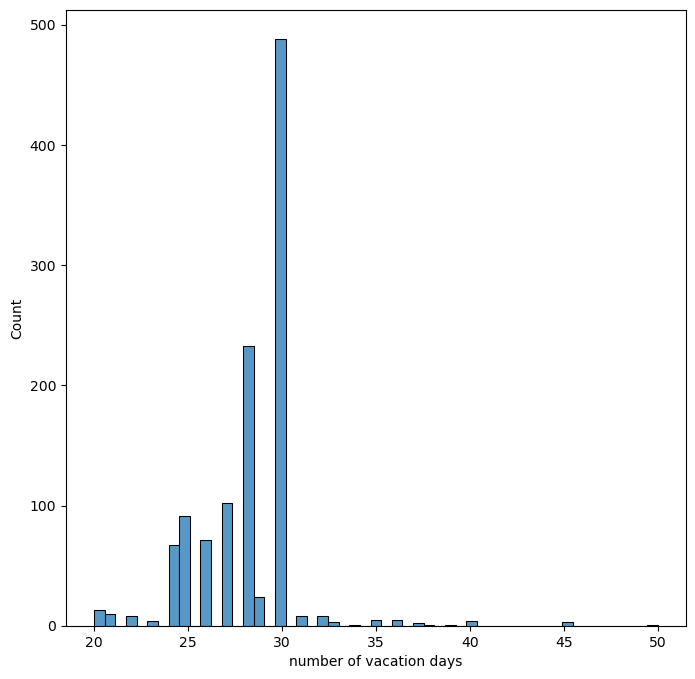

In [ ]:
# Check distribution

sns.histplot(df, x=column);

###  **'Employment status'**
- **Inconsistencies:**
    - null values
    - free form
    - mainly full-time
- **Actions taken:**
    - drop column - not enough variation to be meaningful

In [ ]:
# Basic EDA

column = 'employment status'

tb.eda_column_summary(df, column)

=== COLUMN: employment status ===

DTYPE:
category

NON-NULL VALUES:
1,236

NULL VALUES:
17

UNIQUE VALUES:
10

BASIC STATS:
count                   1236
unique                    10
top       full-time employee
freq                    1190
Name: employment status, dtype: object

TOP VALUES:
employment status
full-time employee            1190
self-employed (freelancer)      28
part-time employee               8
founder                          3
working student                  2
Name: count, dtype: int64

BOTTOM VALUES:
employment status
company director                                                                   1
intern                                                                             1
full-time, but 32 hours per week (it was my request, i'm a student)                1
full-time position, part-time position, & self-employed (freelancing, tutoring)    1
werkstudent                                                                        1
Name: count, dtype: int64


In [ ]:
# Create mapping dictionary

emp_status_map = {
'full-time employee': 'full-time',
 'self-employed (freelancer)': 'self-employed',
 'company director': 'full-time',
 'founder': 'self-employed',
 'part-time employee': 'part-time',
 'working student': 'part-time',
 'full-time position, part-time position, & self-employed (freelancing, tutoring)': 'full-time',
 'intern': 'full-time',
 "full-time, but 32 hours per week (it was my request, i'm a student)": 'full-time',
 'werkstudent': 'part-time'
}

In [ ]:
# Replace values with mapping dictionary

df[column] = df[column].astype(str).replace(emp_status_map)

# Convert back to category

df[column] = df[column].astype('category')


Value counts: employment status
full-time        1194
self-employed      31
nan                17
part-time          11
Name: count, dtype: int64


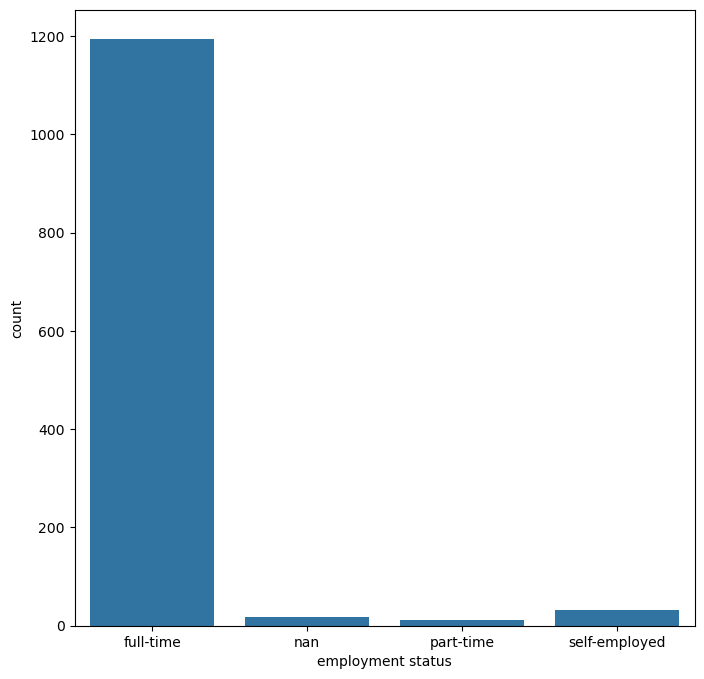

In [ ]:
# Check distribution

sns.countplot(df, x=column);

print(f'Value counts: {df[column].value_counts()}')


###  **'Сontract duration'**
- **Inconsistencies:**
    - null values
    - zero value
- **Actions taken:**
    - replace zero with null
    - impute nulls

In [ ]:
# Basic EDA

column = 'contract duration'

tb.eda_column_summary(df, column)

=== COLUMN: contract duration ===

DTYPE:
category

NON-NULL VALUES:
1,224

NULL VALUES:
29

UNIQUE VALUES:
3

BASIC STATS:
count                   1224
unique                     3
top       unlimited contract
freq                    1159
Name: contract duration, dtype: object

TOP VALUES:
contract duration
unlimited contract    1159
temporary contract      64
0                        1
Name: count, dtype: int64

BOTTOM VALUES:
contract duration
unlimited contract    1159
temporary contract      64
0                        1
Name: count, dtype: int64


In [ ]:
# Check distribution

df[column].value_counts()


contract duration
unlimited contract    1159
temporary contract      64
Name: count, dtype: int64

In [ ]:
# Replace zero value

df[column] = df[column].astype(str).replace('0', pd.NA)

# Convert back to category

df[column] = df[column].astype('category')

###  **'Main language at work'**
- **Inconsistencies:**
    - null values
    - free form
    - mainly just english, some german
- **Actions taken:**
    - drop column - I don't think there is enough variation to be meaningful

In [ ]:
# Basic EDA

column = 'main language at work'

tb.eda_column_summary(df, column)

=== COLUMN: main language at work ===

DTYPE:
category

NON-NULL VALUES:
1,237

NULL VALUES:
16

UNIQUE VALUES:
14

BASIC STATS:
count        1237
unique         14
top       english
freq         1020
Name: main language at work, dtype: object

TOP VALUES:
main language at work
english    1020
german      186
russian      12
spanish       3
italian       3
Name: count, dtype: int64

BOTTOM VALUES:
main language at work
50/50               1
deuglisch           1
both                1
french              1
russian, english    1
Name: count, dtype: int64


Value counts: main language at work
english               1020
german                 186
russian                 12
spanish                  3
italian                  3
czech                    2
polish                   2
pcc                      2
english and german       2
50/50                    1
deuglisch                1
both                     1
french                   1
russian, english         1
Name: count, dtype: int64


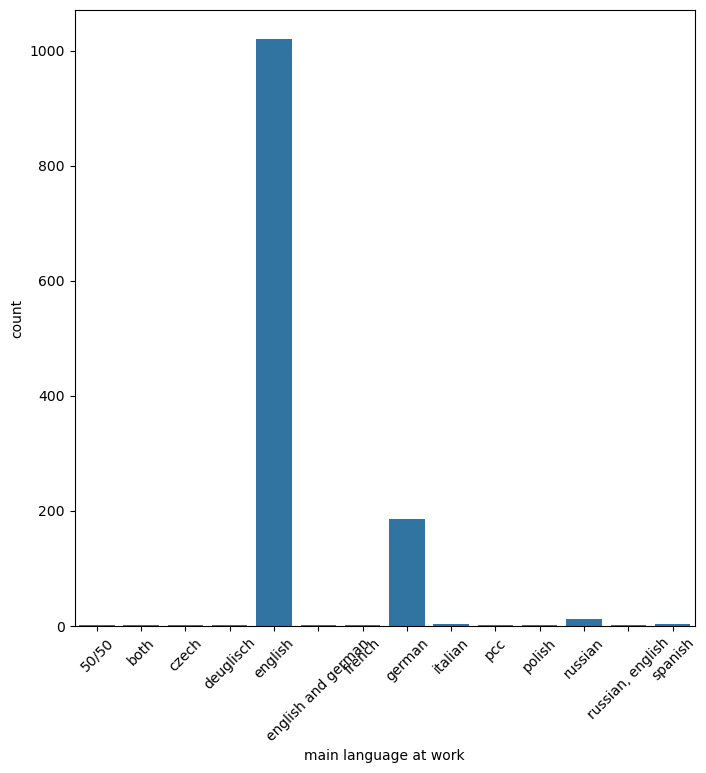

In [ ]:
# Check distribution

sns.countplot(df, x=column)
plt.xticks(rotation=45);

print(f'Value counts: {df[column].value_counts()}')


###  **'Company size'**
- **Inconsistencies:**
    - null values
    - categories already binned but need rank
    - bins don't have same range - not sure if it matters...
- **Actions taken:**
    - impute null values
    - add column with rank
    - drop column from pipeline, use rank instead

In [ ]:
# Basic EDA

column = 'company size'

tb.eda_column_summary(df, column)

=== COLUMN: company size ===

DTYPE:
category

NON-NULL VALUES:
1,235

NULL VALUES:
18

UNIQUE VALUES:
5

BASIC STATS:
count      1235
unique        5
top       1000+
freq        448
Name: company size, dtype: object

TOP VALUES:
company size
1000+       448
101-1000    405
11-50       174
51-100      147
up to 10     61
Name: count, dtype: int64

BOTTOM VALUES:
company size
1000+       448
101-1000    405
11-50       174
51-100      147
up to 10     61
Name: count, dtype: int64


In [ ]:
df[column].unique().tolist()

['51-100', '101-1000', '11-50', '1000+', <NA>, 'up to 10']

In [ ]:
rank_map = {
    'up to 10': 1,
    '11-50': 2,
    '51-100': 3,
    '101-1000': 4,
    '1000+': 5
}

In [ ]:
df['comp_size_rank'] = df[column].map(rank_map)

Value counts: company size
1000+       448
101-1000    405
11-50       174
51-100      147
up to 10     61
Name: count, dtype: int64


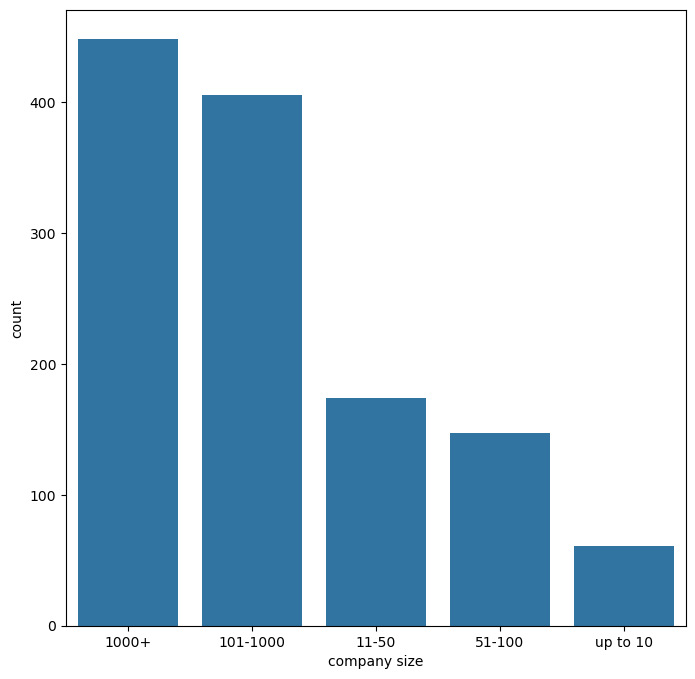

In [ ]:
# Check distribution

sns.countplot(df, x=column);

print(f'Value counts: {df[column].value_counts()}')

###  **'Company type'**
- **Inconsistencies:**
    - null values
    - free form field
    - multiple features per record
- **Actions taken:**
    - impute nulls
    - bin categories

In [ ]:
# Basic EDA

column = 'company type'

tb.eda_column_summary(df, column)

=== COLUMN: company type ===

DTYPE:
category

NON-NULL VALUES:
1,228

NULL VALUES:
25

UNIQUE VALUES:
57

BASIC STATS:
count        1228
unique         57
top       product
freq          760
Name: company type, dtype: object

TOP VALUES:
company type
product                760
startup                252
consulting / agency    142
bank                     6
e-commerce               5
Name: count, dtype: int64

BOTTOM VALUES:
company type
semiconductor            1
systemhaus               1
service                  1
transport & logistics    1
telecommunications       1
Name: count, dtype: int64


In [ ]:
df[column].value_counts()

company type
product                                                                     760
startup                                                                     252
consulting / agency                                                         142
bank                                                                          6
e-commerce                                                                    5
corporation                                                                   3
media                                                                         3
ecommerce                                                                     2
automotive                                                                    2
utilities                                                                     2
fintech                                                                       2
university                                                                    2
research                   

In [ ]:
# Create mapping dictionary to bin these

company_type_map = {
    # Product & Tech Product
    "product": "product",
    "saas": "product",
    "cloud": "product",
    "publishing and technology": "product",
    "faang": "product",
    "game company": "product",

    # Startup
    "startup": "startup",

    # Consulting / Agency / IT Services
    "consulting / agency": "consulting_it",
    "consulting and product": "consulting_it",
    "consulting": "consulting_it",
    "systemhaus": "consulting_it",
    "it-outsourcing": "consulting_it",
    "outsorce": "consulting_it",
    "outsourse": "consulting_it",
    "service": "consulting_it",
    "it department of established business": "consulting_it",

    # Everything else → other
    "university": "other",
    "education": "other",
    "science institute": "other",
    "research": "other",
    "research institute": "other",
    "institute": "other",
    "market research": "other",
    "full-time position in education, part-time position in at a data startup": "other",

    "corporation": "other",
    "enterprise": "other",
    "bloody enterprise": "other",
    "big commercial": "other",
    "concern": "other",
    "corporate incubator": "other",
    "multinational": "other",

    "bank": "other",
    "finance": "other",
    "financial": "other",
    "fintech": "other",
    "insurance": "other",

    "automotive": "other",
    "industry": "other",
    "old industry": "other",
    "semiconductor": "other",
    "construction": "other",
    "consumer goods": "other",
    "pharma": "other",
    "energy": "other",
    "utilities": "other",

    "e-commerce": "other",
    "ecommerce": "other",
    "retail": "other",
    "non-tech retail": "other",
    "handel": "other",

    "media": "other",
    "publisher": "other",

    "transport & logistics": "other",
    "telecommunications": "other",

    "behorde": "other",
    "personal ltd": "other",
    "biergarten": "other",
    "freelance": "other",
}

In [ ]:
# Map the bins

df[column] = df[column].map(company_type_map)

Value counts: company type
product          765
startup          252
consulting_it    149
other             62
Name: count, dtype: Int64


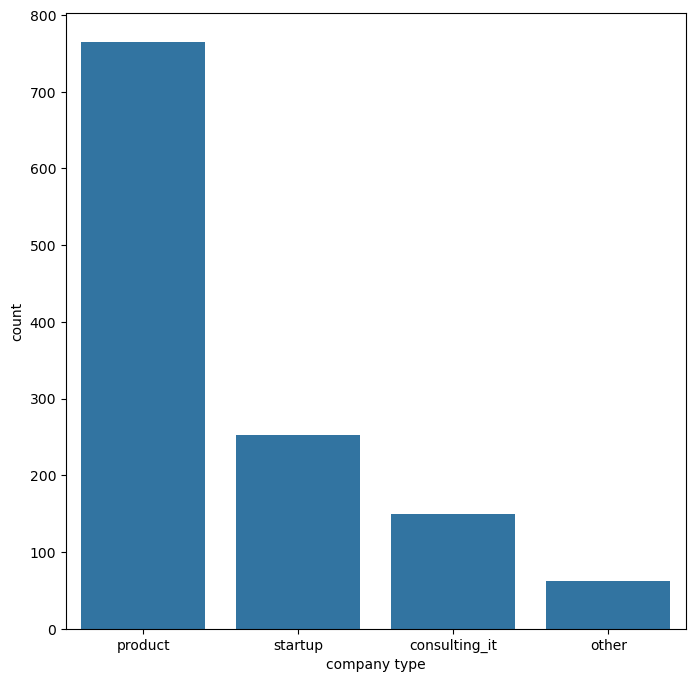

In [ ]:
# Check distribution

sns.countplot(df, x=column);

print(f'Value counts: {df[column].value_counts()}')


## Model

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class logTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        return np.log1p(X)



In [ ]:
df.dtypes

Column
timestamp                                                 datetime64[ns]
age                                                              float64
gender                                                          category
city                                                            category
position                                                        category
total years of experience                                        float64
years of experience in germany                                   float64
seniority level                                                 category
your main technology / programming language                     category
other technologies/programming languages you use often          category
yearly brutto salary (without bonus and stocks) in eur           float64
yearly bonus + stocks in eur                                     float64
number of vacation days                                          float64
employment status                           

In [ ]:
# Predict total_compensation
# Model #1 Random forest

from sklearn.compose import ColumnTransformer                       # Applies transformations to different columns
from sklearn.impute import SimpleImputer                            # Fills in missing values
from sklearn.preprocessing import OneHotEncoder                     # Converts categorical test to numeric dummy variables
from sklearn.preprocessing import MinMaxScaler                      # Scale numeric features to [0,1]
from sklearn.model_selection import cross_val_score                 # Evaluates model with cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression


# Split data into X (features) and y (target), as usual
y = df['total_compensation']
X = df.drop(columns={'total_compensation'})


# Define log transformer for transforming positive skewed data
log_transformer = logTransformer()
pos_skew_features = ['age', 'total years of experience']
pos_skew_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),                # If numeric column has missing values, replace with mean
        ("log", log_transformer),                                   # Transform positives skewed features
        ("scaler", MinMaxScaler())                                  # Rescale each numeric feature so smallest value becomes 0 and largest becomes 1
])

# Define numeric preprocessing
norm_features = [col for col in num_cols if col not in pos_skew_features]
norm_transformer = Pipeline(steps=[                 
        ("imputer", SimpleImputer(strategy="mean")),                # If numeric column has missing values, replace with mean
        ("scaler", MinMaxScaler())                                  # Rescale each numeric feature so smallest value becomes 0 and largest becomes 1
    ])

# Define categorical preprocessing
categorical_features = cat_cols
categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])    

# Combine preprocessing steps with ColumnTransformer
preprocessor = ColumnTransformer(remainder='drop',                 
        transformers=[
        ("log_num", pos_skew_transformer, pos_skew_features),
        ("num", norm_transformer, norm_features),             # Apply numeric pipeline to numeric columns
        ("cat", categorical_transformer, categorical_features),     # Apply one-hot encoder to categorical columns
    ])

# Create full pipeline 
model = RandomForestRegressor(random_state=42)                                                                            
pipe = Pipeline(steps=[
    ('pre', preprocessor),                         # Stage 1: "Pre" - run ColumnTransformer
    ('select', SelectKBest(score_func=f_regression)),
    ('model', model)])                             # Stage 2: "Model" - fit a random forest regression model)                                     


# Create gridsearch
param_grid = {
    "select__k": [10, 20, 30, "all"],
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

# Convert all categorical columns to object dtype
for col in cat_cols:
    X[col] = X[col].astype(object)

# Replace pd.NA cuz it doesn't like it for some reason
X = X.replace({pd.NA: np.nan})

# Get rid of rows where target value is null
mask = ~y.isna()
X = X[mask]
y = y[mask]


# Split data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the model
grid.fit(X_train, y_train)
pipe.fit(X_train, y_train)                                        # Fit imputer, scaler, and encoder on training data
cvs = cross_val_score(pipe, X_train, y_train.ravel(), cv=5)       # Split training data into 5 folds


print('Training CrossVal Score:', cvs)
print("Average Train Score:", np.mean(cvs))
print('Testing score:', pipe.score(X_test, y_test))               # Evaluate the model on testing data (returns R^2 score)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)
print("Test score:", grid.score(X_test, y_test))

C:\Users\msieb\AppData\Local\Temp\ipykernel_18628\1321423042.py:81: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({pd.NA: np.nan})
C:\Users\msieb\AppData\Local\Temp\ipykernel_18628\1321423042.py:95: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cvs = cross_val_score(pipe, X_train, y_train.ravel(), cv=5)       # Split training data into 5 folds


Training CrossVal Score: [ 0.98024817  0.99471113  0.98059551  0.99162904 -0.00760367]
Average Train Score: 0.7879160363971444
Testing score: 0.5087842756503373
Best params: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 400, 'select__k': 10}
Best CV score: 0.7894706206969259
Test score: 0.5081255206117761


# Answers and Explainations
(Expand/modify as needed)

### Here's the Data Cleaning Steps I Used

### Here's my Tuning/Feature Selection Steps

### Here's my Model's Performance

### Here's my Final Conclusion on What Worked Best